# Synthetic dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split

from GeoConformalizedExplainer import GeoConformalizedExplainer

C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Plot Functions

In [2]:
plt.rcParams['legend.fontsize'] = 16


def plot_s(b, k=3, size=50, filename=None, sub_titles=None, non_spatial=None, vmin=None, vmax=None, interpolation=None,
           cmap=plt.get_cmap('viridis', 36)):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)

    for i in range(k):
        ax = axes[i]
        if i in non_spatial:
            ax.scatter(b[i][0], b[i][1], s=5, color='black')
            ax.set_ylim(b[i][2], b[i][3])
            ax.set_xlim(-2.5, 2.5)
            ax.set_xlabel(r'$X_{}$'.format(i), fontsize=16)
            ax.xaxis.set_tick_params(labelsize=20)
            ax.yaxis.set_tick_params(labelsize=20)
            ax.grid(False)
        else:
            if vmin is None:
                v_min = np.floor(b[i].min() * 10) / 10
            else:
                v_min = vmin
            if vmax is None:
                v_max = np.ceil(b[i].max() * 10) / 10
            else:
                v_max = vmax
            c = ax.imshow(b[i].reshape(size, size), cmap=cmap, vmin=v_min, vmax=v_max, interpolation=interpolation)
            cb = fig.colorbar(c, ax=ax)
            cb.ax.tick_params(labelsize=20)
            ax.set_xticks(np.arange(-0.5, size, 5))
            ax.set_yticks(np.arange(-0.5, size, 5))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_axis_off()
            ax.tick_params(axis='x', colors=(0, 0, 0, 0))
            ax.tick_params(axis='y', colors=(0, 0, 0, 0))
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')

In [3]:
def plot_uncertainty(u, k=3, title=None, sub_titles=None, cmap='flare', s_limits=(5, 20), hue='geo_uncertainty',
                     size='shap_abs'):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)
    sns.set_style("white")

    for i in range(k):
        ax = axes[i]
        data = u[i]
        g = sns.scatterplot(data=data, x='x', y='y', hue=hue, size=size, palette=cmap, sizes=s_limits, legend=False,
                            edgecolor='.7', ax=ax)
        g.set(xlabel='', ylabel='', aspect='equal')
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)

    plt.savefig(f'{title}.pdf', bbox_inches='tight')


In [4]:
def plot_coverage(c, k=3, size=50, title=None, sub_titles=None, colors=None, cmap=None):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)
    legend_elements = [Patch(facecolor=colors[0], edgecolor='.7', label='Not Covered'),
                       Patch(facecolor=colors[1], edgecolor='.7', label='Covered')]
    for i in range(k):
        ax = axes[i]
        ax.imshow(c[i].reshape(size, size), cmap=cmap, vmin=0, vmax=1)
        ax.legend(handles=legend_elements, loc='upper right', title='')
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)
    plt.savefig(f'{title}.pdf', bbox_inches='tight')


## Uncertainty Generation

In [5]:
from scipy.stats import multivariate_normal

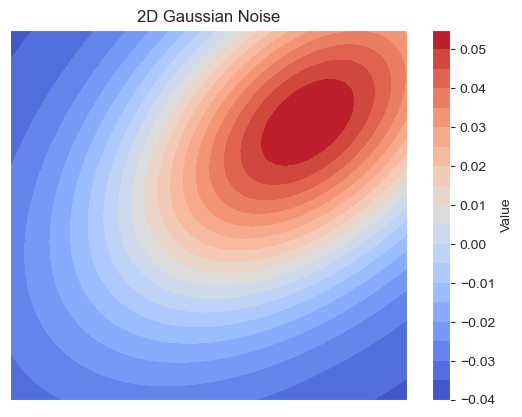

In [6]:
x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
mean = [1, 1]
covariance = [[2, 1], [1, 2]]
rv = multivariate_normal(mean, covariance)
n1 = rv.pdf(pos)
n1 = n1 - n1.mean()

X_ = np.arange(0, 50)
Y_ = np.arange(0, 50)
# Plot the distribution
plt.contourf(X_, Y_, n1, levels=20, cmap='coolwarm')
plt.colorbar(label='Value')
plt.title('2D Gaussian Noise')
plt.xticks([])
plt.yticks([])
plt.savefig('./noise_noise.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [7]:
n1.max()

0.05485261423721707

In [8]:
n1.min()

-0.03581686381294749

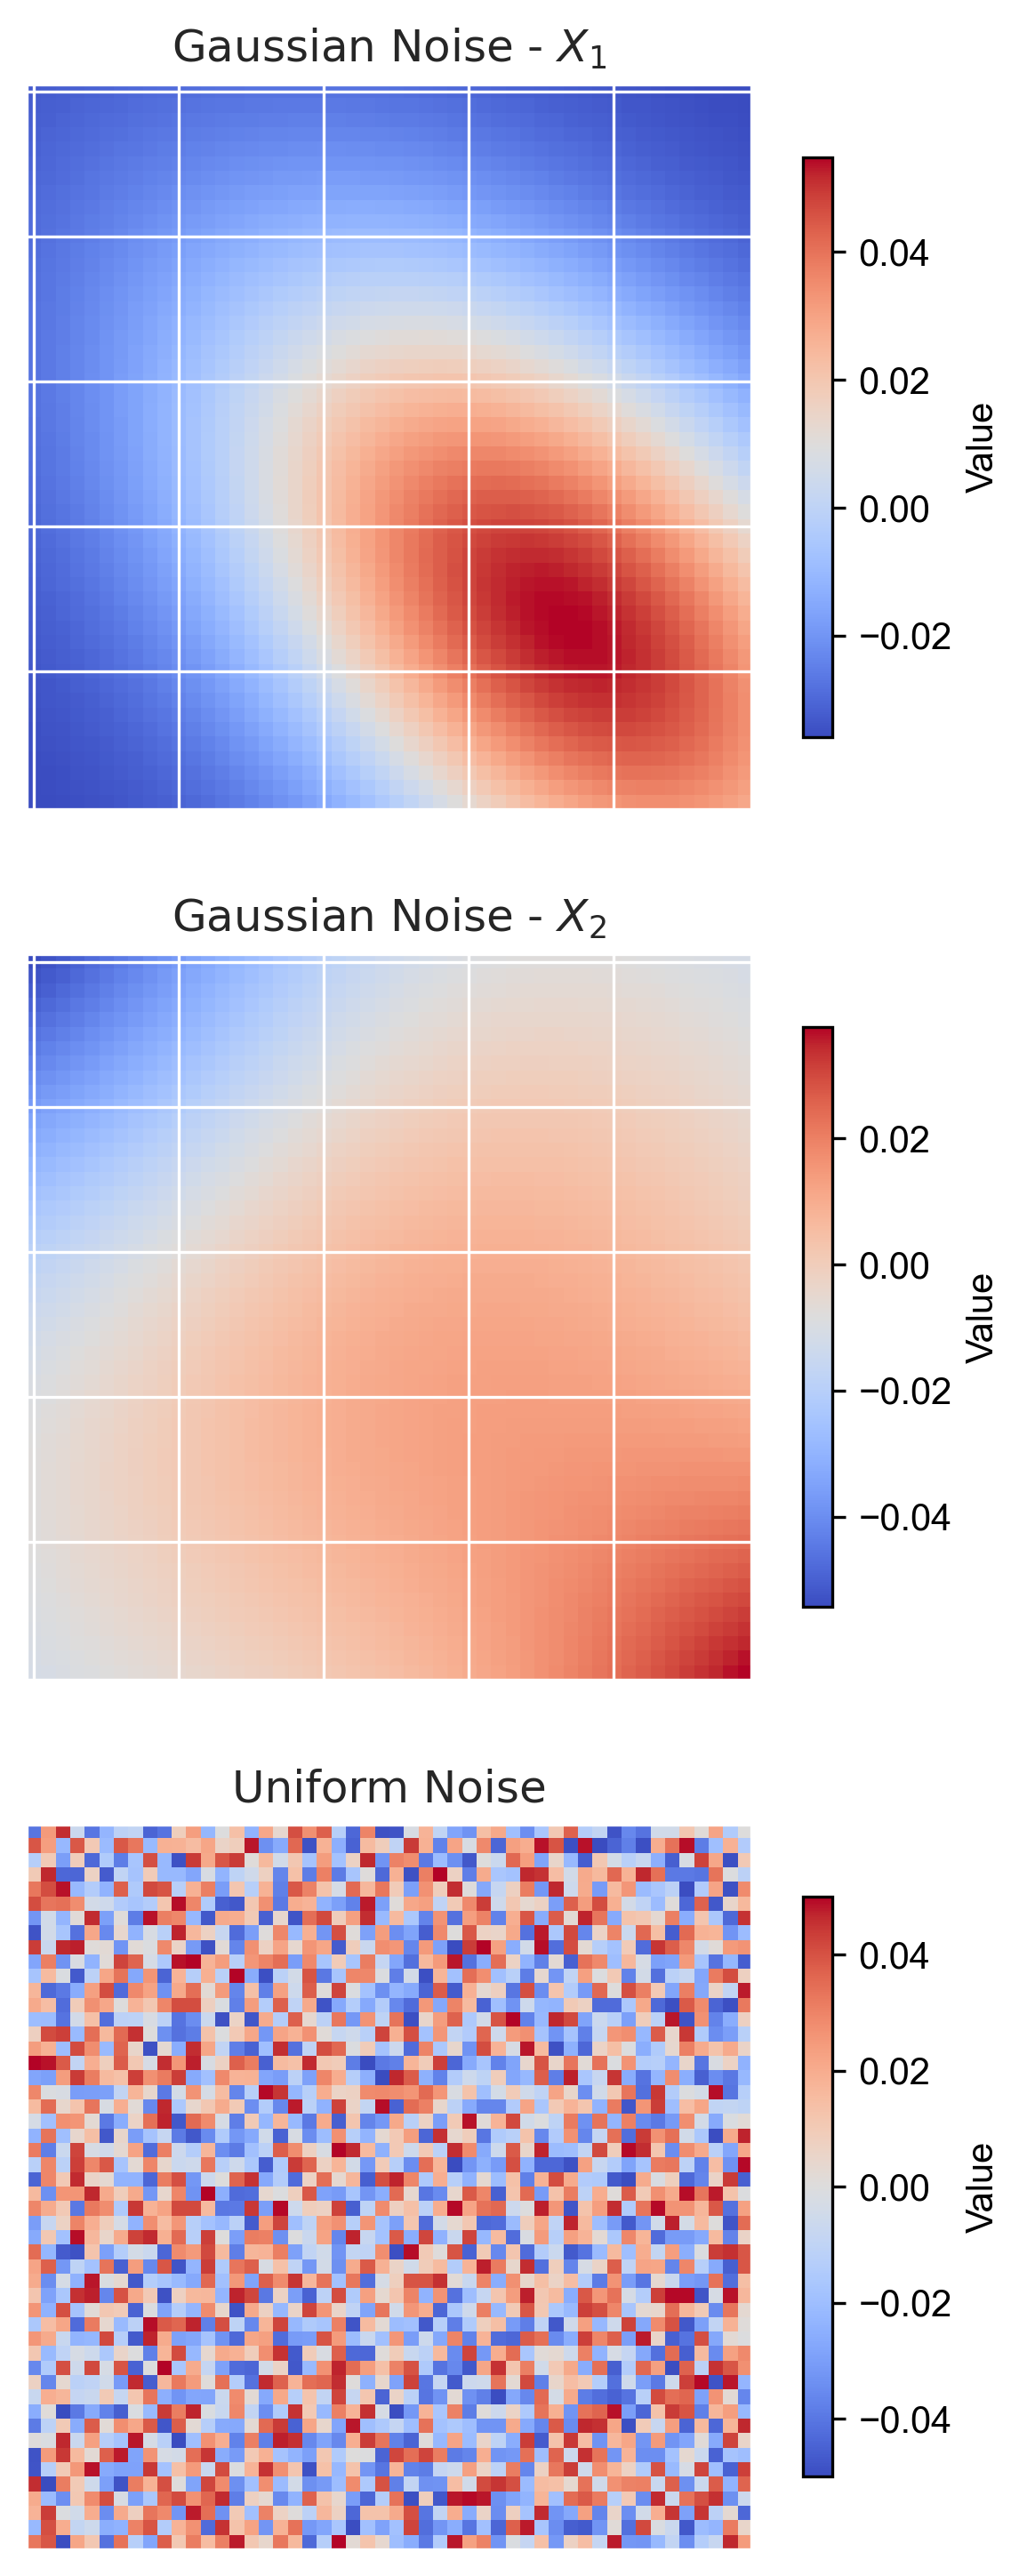

In [9]:
fig, axes = plt.subplots(3, 1, dpi=300, figsize=(5, 12))
plt.style.use('default')
plt.rcParams['font.family'] = 'Arial'
plt.grid(False)
x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
mean = [1, 1]
covariance = [[2, 1], [1, 2]]
rv = multivariate_normal(mean, covariance)
n1 = rv.pdf(pos)
n1 = n1 - n1.mean()
X_ = np.arange(0, 50)
Y_ = np.arange(0, 50)

im0 = axes[0].imshow(n1, cmap='coolwarm')
# axes[0].invert_yaxis()
cbar0 = fig.colorbar(im0, label='Value', shrink=0.8)
axes[0].set_title(r'Gaussian Noise - $X_1$')
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])

gaussians = [
    multivariate_normal([3, 3], [[2, 0], [0, 2]]).pdf(pos),
    multivariate_normal([-3, -3], [[3, 1], [1, 3]]).pdf(pos),
    multivariate_normal([0, 0], [[4, 0], [0, 4]]).pdf(pos)
]

n_mg = (gaussians[0] - gaussians[1] + gaussians[2])
n_mg = n_mg - n_mg.mean()

im1 = axes[1].imshow(n_mg, cmap='coolwarm')
# axes[0].invert_yaxis()
cbar1 = fig.colorbar(im1, label='Value', shrink=0.8)
axes[1].set_title(r'Gaussian Noise - $X_2$')
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])

n_u = np.random.uniform(-0.05, 0.05, size=(50, 50))

im2 = axes[2].imshow(n_u, cmap='coolwarm')
fig.colorbar(im2, label='Value', shrink=0.8)
axes[2].set_title('Uniform Noise')
axes[2].set_xticklabels([])
axes[2].set_yticklabels([])

plt.savefig('./noise_gaussian_and_uniform_level_10.pdf', bbox_inches='tight', dpi=300, format='pdf')
plt.show()

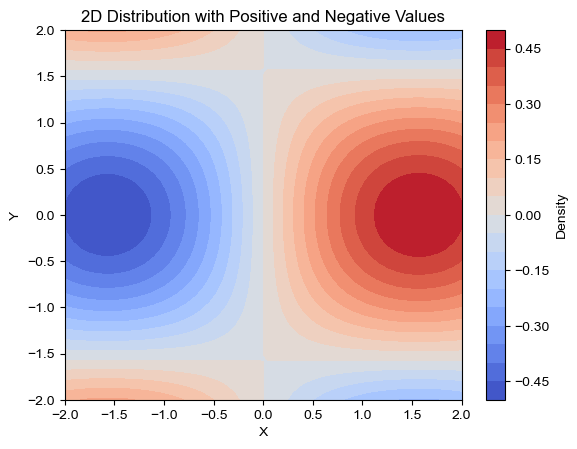

In [10]:
x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)
X, Y = np.meshgrid(x, y)
n2 = np.sin(X) * np.cos(Y) / 2

# Plot the distribution
plt.contourf(X, Y, n2, levels=20, cmap='coolwarm')
plt.colorbar(label='Density')
plt.title('2D Distribution with Positive and Negative Values')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

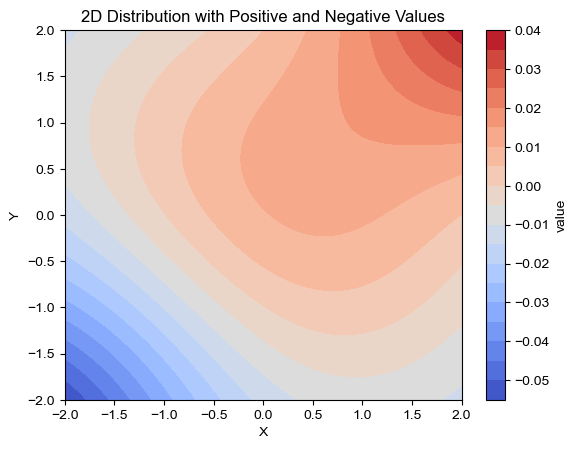

In [11]:
x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)
X, Y = np.meshgrid(x, y)

gaussians = [
    multivariate_normal([3, 3], [[2, 0], [0, 2]]).pdf(pos),
    multivariate_normal([-3, -3], [[3, 1], [1, 3]]).pdf(pos),
    multivariate_normal([0, 0], [[4, 0], [0, 4]]).pdf(pos)
]

n3 = (gaussians[0] - gaussians[1] + gaussians[2])
n3 = n3 - n3.mean()

# Plot the distribution
plt.contourf(X, Y, n3, levels=20, cmap='coolwarm')
plt.colorbar(label='value')
plt.title('2D Distribution with Positive and Negative Values')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [12]:
n3.max()

0.03768632392947922

In [13]:
n3.min()

-0.05429387037032835

## Data generation

In [14]:
size = 50

b1 = np.ones((size, size))
b2 = np.ones((size, size))

for i in range(size):
    for j in range(size):
        b1[i, j] = (i + j) / 49 * 3
        b2[i, j] = 3 * (np.sin(-2 + 4 / 49 * i) * np.cos(-2 + 4 / 49 * j) + 1)


In [15]:
print(f'{n1.max()},{n1.min()}')
print(f'{n3.max()},{n3.min()}')
print(f'{n_mg.max()},{n_mg.min()}')

0.05485261423721707,-0.03581686381294749
0.03768632392947922,-0.05429387037032835
0.03768632392947922,-0.05429387037032835


In [16]:
b1 = b1.reshape(-1)
b2 = b2.reshape(-1)
n1_ = n1.reshape(-1)
n2_ = n2.reshape(-1)
n3_ = n3.reshape(-1)

In [17]:
np.random.seed(222)

X1 = np.random.uniform(-2, 2, size * size)
X2 = np.random.uniform(-2, 2, size * size)
X3 = np.random.uniform(-2, 2, size * size)
X4 = np.random.uniform(-2, 2, size * size)

X = np.vstack([X1, X2, X3, X4]).T
u = np.array([np.linspace(0, size - 1, num=size)] * size).reshape(-1)
v = np.array([np.linspace(0, size - 1, num=size)] * size).T.reshape(-1)
coords = np.array(list(zip(u, v)))

k = X.shape[1]
n = X.shape[0]

In [18]:
X_coords = pd.DataFrame(np.concatenate((X, np.array(coords)), axis=1),
                        columns=['X1', 'X2', 'X3', 'X4', 'x_coord', 'y_coord'])

In [19]:
X_coords

X1        X2        X3        X4  x_coord  y_coord
0     0.104114  0.964917  1.011381  1.192011      0.0      0.0
1     0.741269 -0.440030 -0.936705  1.024414      1.0      0.0
2     1.342697 -0.875739 -1.148677 -1.992029      2.0      0.0
3     0.615061  1.082512 -1.266801 -0.424231      3.0      0.0
4    -1.851912  0.026923 -0.659943  1.062233      4.0      0.0
...        ...       ...       ...       ...      ...      ...
2495 -1.798074 -0.779403  0.012337 -1.363451     45.0     49.0
2496  0.239688 -0.666447  0.497581  0.348732     46.0     49.0
2497 -1.719665 -1.038000 -0.700350  1.508266     47.0     49.0
2498 -0.650496 -1.045958  0.776005  1.999300     48.0     49.0
2499  0.801800 -0.750421  0.581807  0.487717     49.0     49.0

[2500 rows x 6 columns]

In [20]:
# f0 = b0
f1 = (b1 + n1_) * X_coords.values[:, 0]
f2 = (b2 + n2_) * X_coords.values[:, 1]
f3 = X_coords.values[:, 2] ** 2
f4 = np.abs(X_coords.values[:, 3]) * 2

In [21]:
y = pd.DataFrame(f1 + f2 + f3 + f4, columns=['y'])

In [22]:
b = [b1, b2, [X_coords.values[:, 2], f3, -1, 5], [X_coords.values[:, 3], f4, -1, 5]]
# b = [b1, b2, b3, [X_coords.values[:, 3], f4, -6, 6], [X_coords.values[:, 4], f5, -1, 5]]

In [23]:
sub_titles = [r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$f_{3}(X_3)$', r'$f_4(X_4)$']
# sub_titles = [r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$\beta_{3}(u, v)$', r'$f_4(X_4)$', r'$f_5(X_5)$']

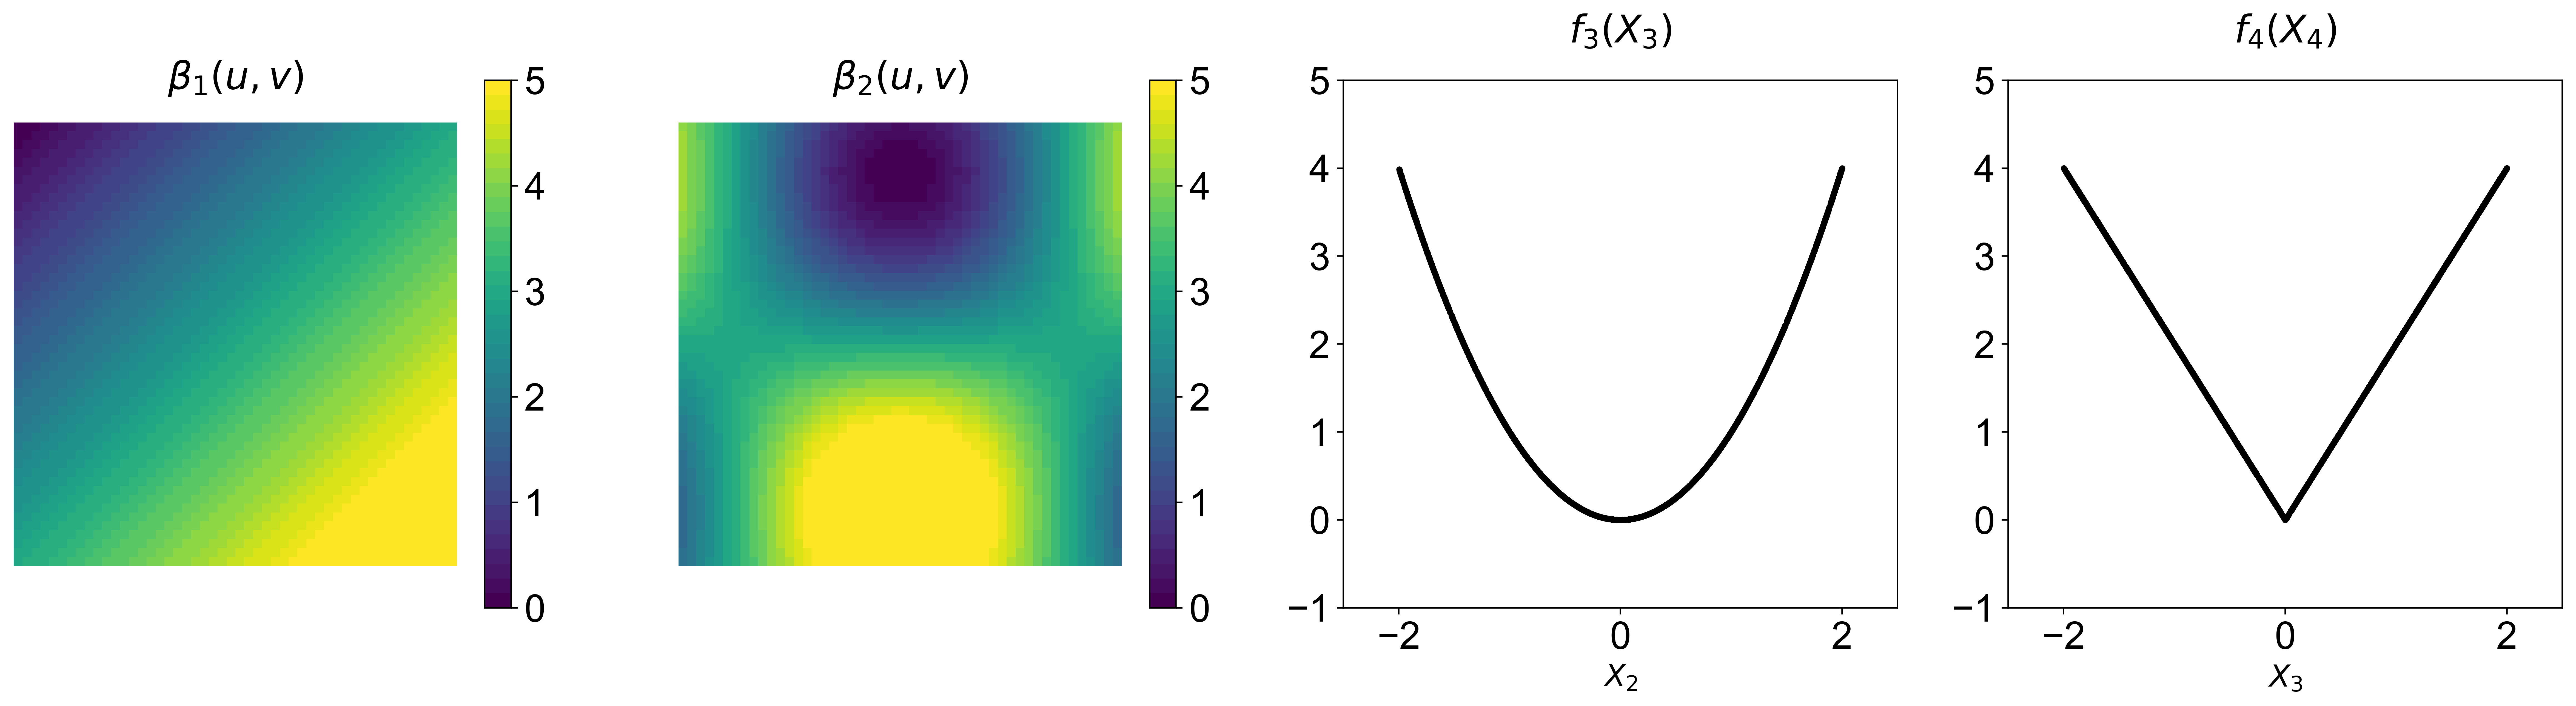

In [24]:
plot_s(b=b, k=4, sub_titles=sub_titles, vmin=0, vmax=5, filename='TrueModel.pdf', non_spatial=[2, 3], size=size)

In [25]:
b_n = [b1 + n1_, b2 + n3_, n1_, n3_]

In [26]:
sub_titles_bn = [r'$\beta_1(u,v) + n_1(u,v)$', r'$\beta_2(u,v) + n_2(u,v)$', r'$n_1$',
                 r'$n_2$']

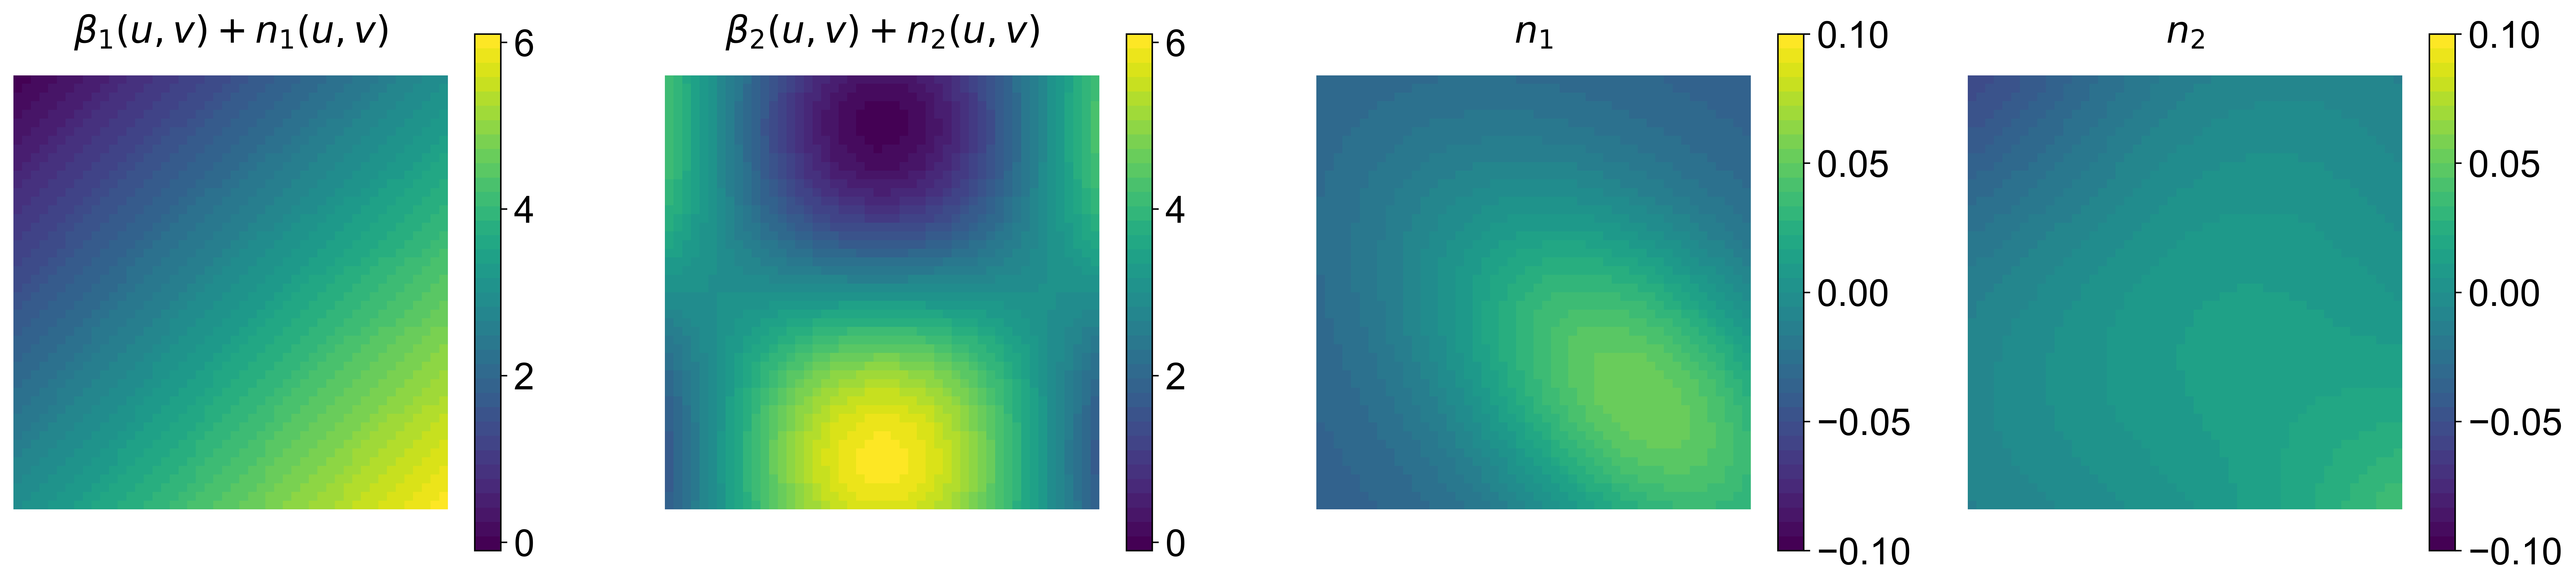

In [27]:
plot_s(b=b_n, k=4, sub_titles=sub_titles_bn, filename='TrueModel_with_noise.pdf', non_spatial=[], size=size)

In [28]:
def true_model_predict(X_coords):
    try:
        X_coords = X_coords.values
    except:
        pass
    u = X_coords[:, -1].astype(int)
    v = X_coords[:, -2].astype(int)
    b_1 = (u + v) / 49 * 2.5
    b_2 = 3 * (np.sin(-2 + 4 / 49 * u) * np.cos(-2 + 4 / 49 * v) + 1)
    # f1 = (b1 + n1[u, v]) * X_coords[:, 0]
    # f2 = (b2 + n2[u, v]) * X_coords[:, 1]
    # f3 = (b3 + n3[u, v]) * X_coords[:, 2]
    f1 = b_1 * X_coords[:, 0]
    f2 = b_2 * X_coords[:, 1]
    f3 = X_coords[:, 2] ** 2
    f4 = np.abs(X_coords[:, 3]) * 2
    y_pred = f1 + f2 + f3 + f4
    return y_pred

In [66]:
def biased_model_predict(X_coords, noise_level=50):
    try:
        X_coords = X_coords.values
    except:
        pass
    u = X_coords[:, -1].astype(int)
    v = X_coords[:, -2].astype(int)
    b_1 = (u + v) / 49 * 2.5 + n1_.reshape(50, 50)[u, v]
    b_2 = 3 * (np.sin(-2 + 4 / 49 * u) * np.cos(-2 + 4 / 49 * v) + 1) + n3_.reshape(50, 50)[u, v]
    # f1 = (b1 + n1[u, v]) * X_coords[:, 0]
    # f2 = (b2 + n2[u, v]) * X_coords[:, 1]
    # f3 = (b3 + n3[u, v]) * X_coords[:, 2]
    f1 = (b_1 + n1[u, v] * noise_level) * X_coords[:, 0]
    f2 = (b_2 + n3[u, v] * noise_level) * X_coords[:, 1]
    f3 = X_coords[:, 2] ** 2
    f4 = np.abs(X_coords[:, 3]) * 2
    y_pred = f1 + f2 + f3 + f4
    return y_pred

In [30]:
true_model_predict(X_coords)

array([ 7.39704242,  1.23511329,  2.1854651 , ..., -7.28565516,
       -0.78451875,  3.92355171])

In [31]:
biased_model_predict(X_coords)

array([  4.55290665,   1.20668969,   2.2998166 , ..., -11.92305082,
        -3.7303195 ,   3.65965924])

In [32]:
def shap_value_f(x):
    # explainer_ = KernelExplainer(true_model_predict, x)
    # explainer_.stratify_background_set(5)
    # result = explainer_.calculate_shap_values(x, verbose=False, background_fold_to_use=0)
    # explainer = shap.PermutationExplainer(true_model_predict, x)
    # result = explainer(x).values
    background = shap.sample(x, 50)
    background[:, :-2] = 0
    explainer = shap.KernelExplainer(biased_model_predict, background)
    result = explainer(x).values
    return result

In [33]:
def shap_value_f(x, function=true_model_predict):
    explainer = shap.ExactExplainer(function, x)
    result = explainer(x).values
    return result

In [34]:
loc = X_coords[['x_coord', 'y_coord']]

In [35]:
X_train, X_temp, loc_train, loc_temp = train_test_split(X_coords, loc, train_size=0.8)

In [36]:
X_calib, X_test, loc_calib, loc_test = train_test_split(X_temp, loc_temp, train_size=0.5)

In [67]:
noise_50_model_predict = lambda x_: biased_model_predict(x_, 50)

In [68]:
noise_100_model_predict = lambda x_: biased_model_predict(x_, 100)

In [69]:
noise_200_model_predict = lambda x_: biased_model_predict(x_, 200)

In [70]:
noise_500_model_predict = lambda x_: biased_model_predict(x_, 500)

In [97]:
explainer = GeoConformalizedExplainer(prediction_f=noise_200_model_predict,
                                      x_train=X_train,
                                      x_calib=X_calib,
                                      coord_calib=loc_calib.values,
                                      miscoverage_level=0.1,
                                      band_width=5,
                                      shap_value_f=lambda x_: shap_value_f(x_, noise_200_model_predict),
                                      feature_names=X_calib.columns)

In [98]:
results = explainer.uncertainty_aware_explain(x_test=X_coords, coord_test=loc.values)

Explaining Variables


In [99]:
results.accuracy_summary()

Mean(|SHAP_value|)  Uncertainty        R2      RMSE   SHAP_Var  \
X1                 3.232636     2.980571  0.992670  0.415150  23.513705   
X2                 3.454765     1.623745  0.953523  0.949820  19.410971   
X3                 1.000167     0.319894  0.949796  0.266277   1.412315   
X4                 1.003850     0.173311  0.982096  0.155225   1.345792   
x_coord            2.072885     1.092288  0.962410  0.566360   8.533117   
y_coord            2.302598     2.265635  0.940613  0.775428  10.125003   

         Pred_SHAP_Var  
X1           24.122462  
X2           18.947425  
X3            1.415252  
X4            1.335245  
x_coord       8.206075  
y_coord       9.508420

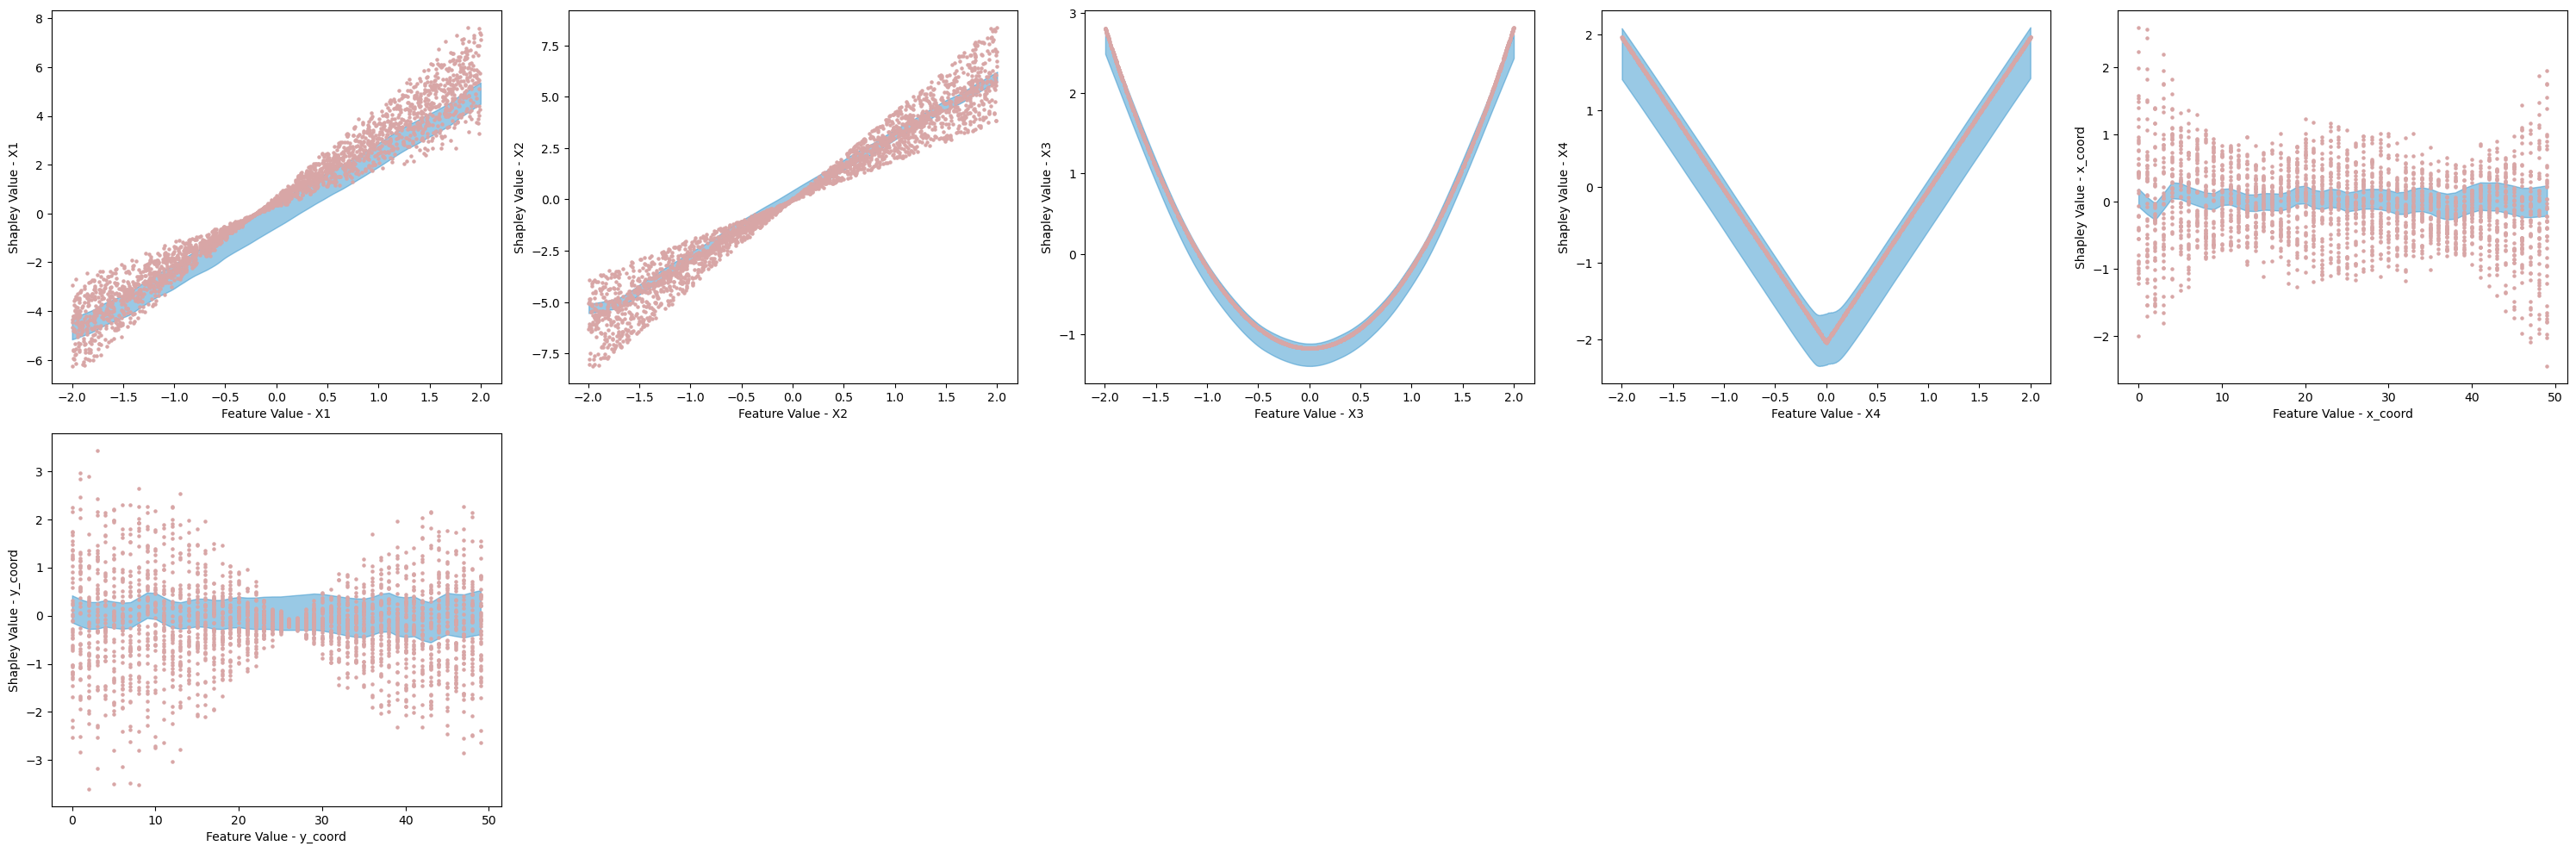

In [40]:
results.plot_partial_dependence_with_fitted_bounds()

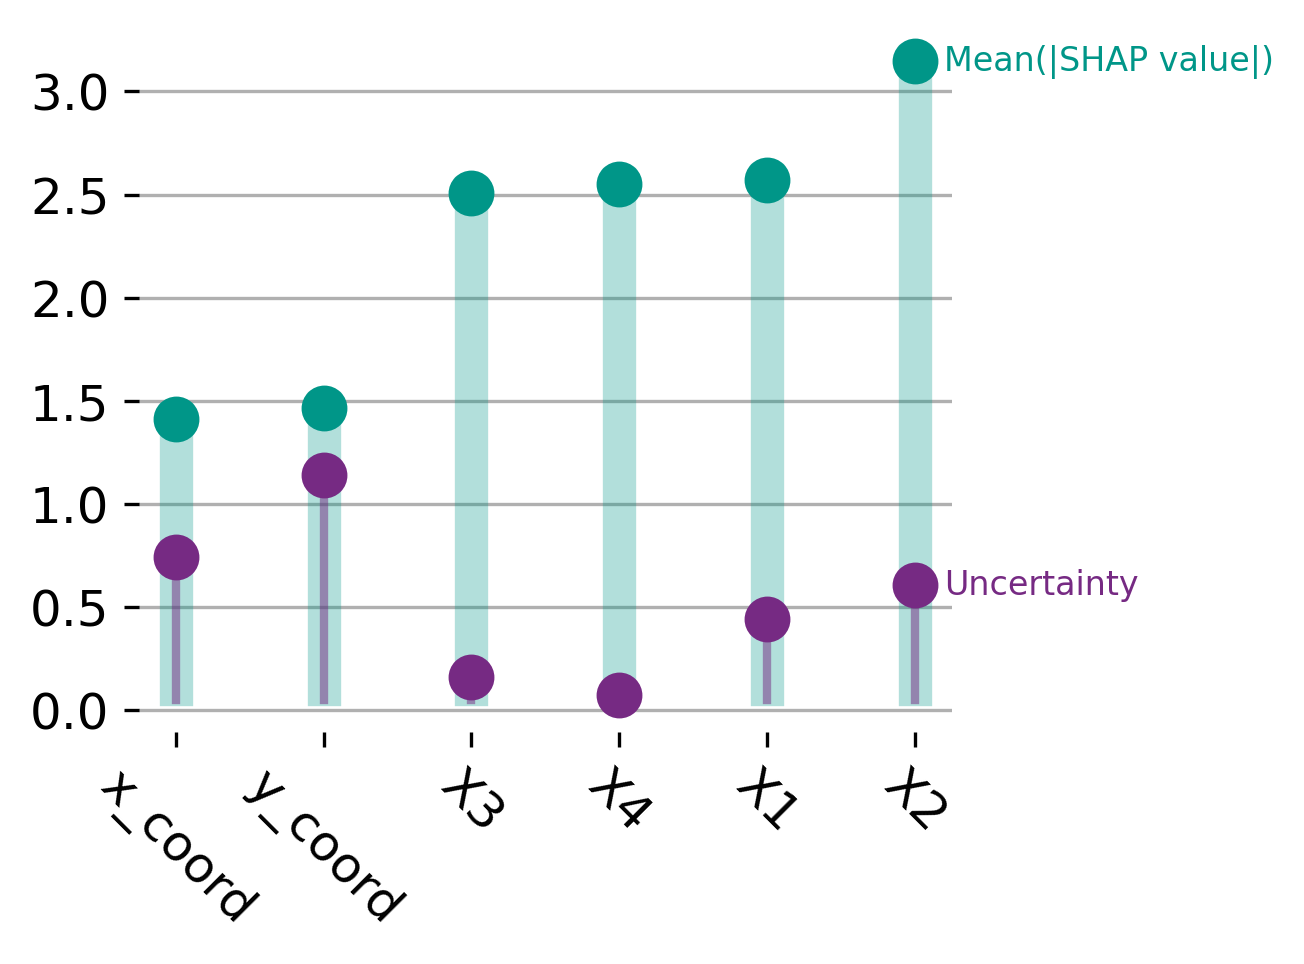

In [137]:
results.plot_absolute_shap_value_with_uncertainty(filename='./SHAP_Uncertainty_Kernel_50.pdf')

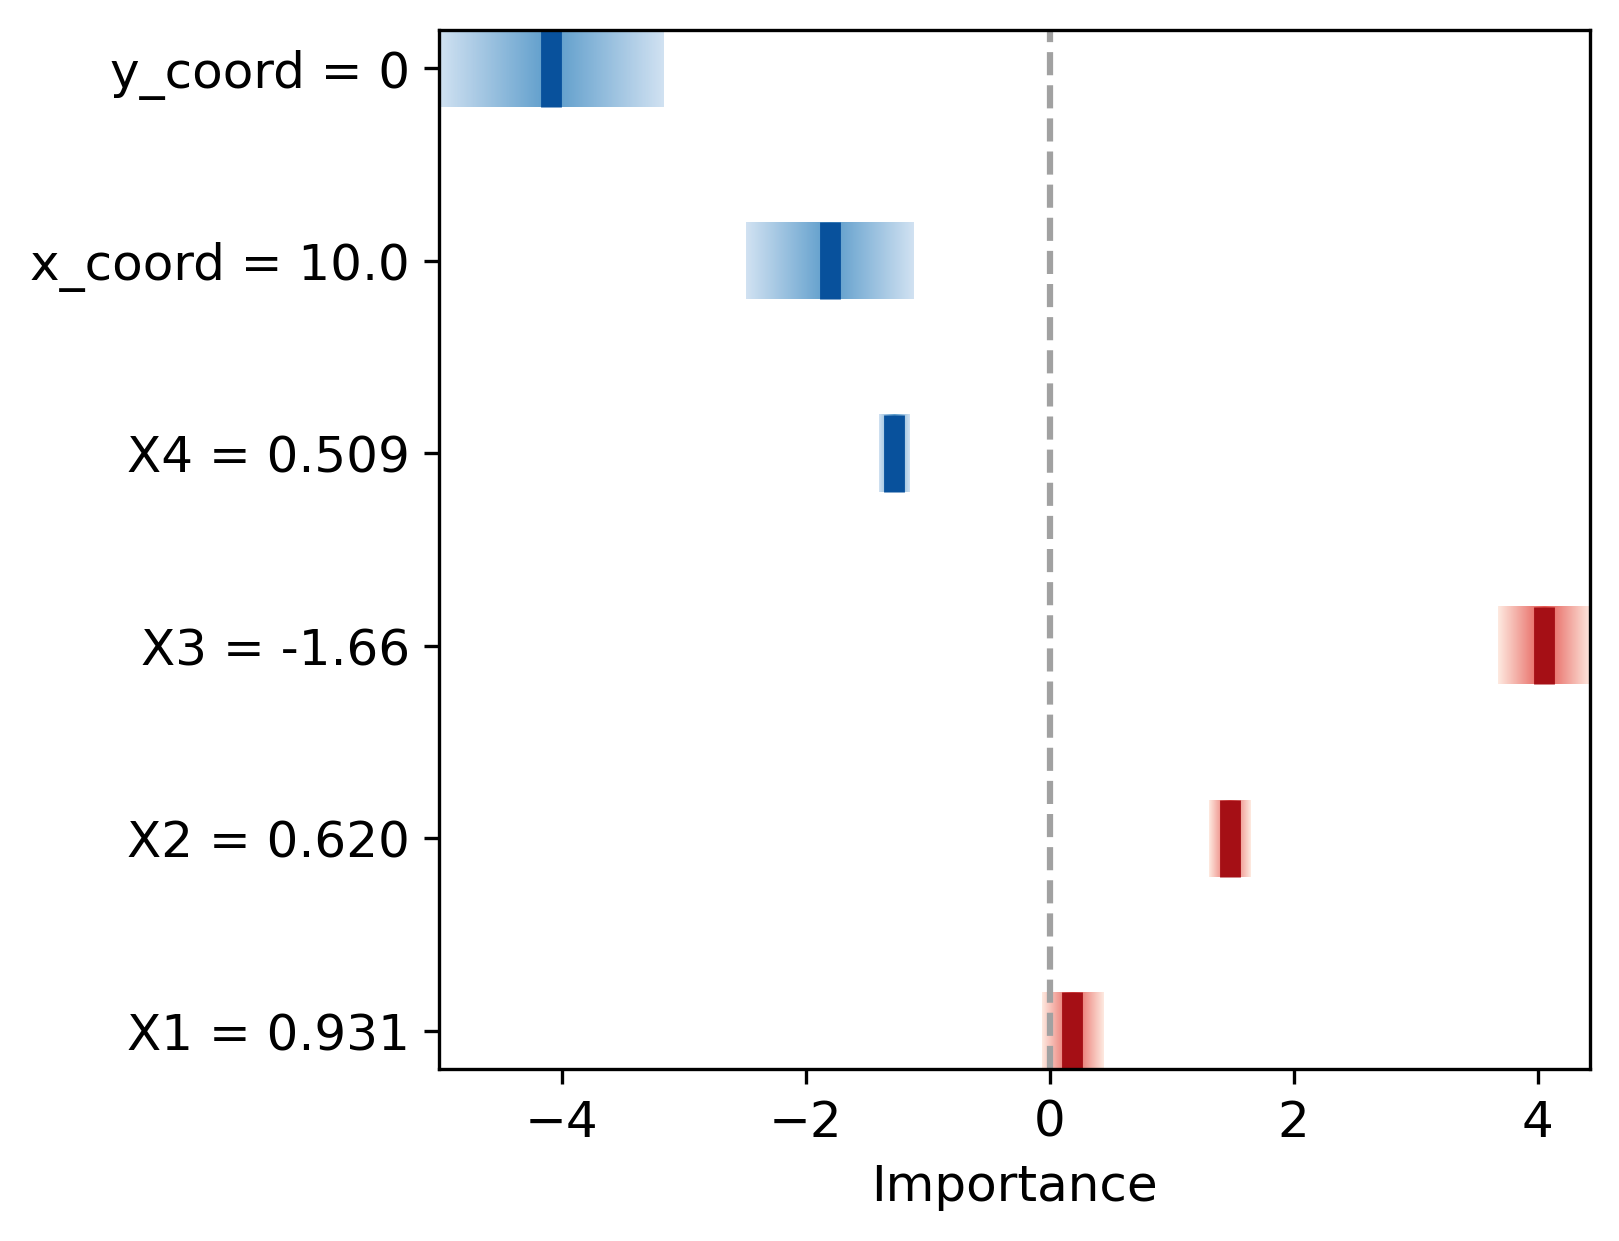

In [100]:
results.plot_shap_values_with_uncertainty(10)

In [100]:
pred_results = results.result_geo

In [101]:
pred_results

X1_shap   X2_shap   X3_shap   X4_shap  x_coord_shap  y_coord_shap  \
0     -0.681871 -1.782153 -0.152241  0.344131     -1.661209     -2.320882   
1     -2.243387  0.350418 -0.297716  0.008937      0.319879      0.542932   
2     -3.612930  0.923909  0.144326  1.944166      0.179293      0.615352   
3     -1.790148 -1.710209  0.429653 -1.191429     -2.596094     -3.875432   
4      3.792263 -0.323809 -0.739607  0.084575      3.614419      4.645474   
...         ...       ...       ...       ...           ...           ...   
2495 -10.689307 -4.807241 -1.174980  0.687012     -6.370184     -5.287855   
2496   3.106355 -4.128671 -0.927545 -1.342427     -0.273247     -1.297703   
2497  -9.825802 -6.445974 -0.684641  0.976641     -6.099924     -5.924777   
2498  -2.732005 -6.516115 -0.572948  1.958710     -3.111366     -3.862742   
2499   6.450481 -4.689951 -0.836633 -1.064457      0.906922     -0.324886   

      X1_value  X2_value  X3_value  X4_value  ...  y_coord_geo_uncertainty  \
0     0.104114  0.964917  1.011381  1.192011  ...                 1.006088   
1     0.741269 -0.440030 -0.936705  1.024414  ...                 1.006088   
2     1.342697 -0.875739 -1.148677 -1.992029  ...                 1.006088   
3     0.615061  1.082512 -1.266801 -0.424231  ...                 1.006088   
4    -1.851912  0.026923 -0.659943  1.062233  ...                 1.038383   
...        ...       ...       ...       ...  ...                      ...   
2495 -1.798074 -0.779403  0.012337 -1.363451  ...                 3.610791   
2496  0.239688 -0.666447  0.497581  0.348732  ...                 3.610791   
2497 -1.719665 -1.038000 -0.700350  1.508266  ...                 3.610791   
2498 -0.650496 -1.045958  0.776005  1.999300  ...                 3.610791   
2499  0.801800 -0.750421  0.581807  0.487717  ...                 3.610791   

      y_coord_uncertainty  y_coord_upper_bound  y_coord_lower_bound  \
0                2.265635            -2.281452            -4.293628   
1                2.265635             0.366513            -1.645663   
2                2.265635             0.310880            -1.701296   
3                2.265635            -3.751896            -5.764072   
4                2.265635             4.755860             2.679095   
...                   ...                  ...                  ...   
2495             2.265635            -1.228044            -8.449626   
2496             2.265635             3.276280            -3.945302   
2497             2.265635            -1.344137            -8.565719   
2498             2.265635             0.703281            -6.518300   
2499             2.265635             4.033073            -3.188508   

      y_coord_coverage_probability  y_coord_pred  y_coord_shap_abs     x  \
0                           0.9932     -3.287540          2.320882   0.0   
1                           0.9932     -0.639575          0.542932   1.0   
2                           0.9932     -0.695208          0.615352   2.0   
3                           0.9932     -4.757984          3.875432   3.0   
4                           0.9932      3.717477          4.645474   4.0   
...                            ...           ...               ...   ...   
2495                        0.9932     -4.838835          5.287855  45.0   
2496                        0.9932     -0.334511          1.297703  46.0   
2497                        0.9932     -4.954928          5.924777  47.0   
2498                        0.9932     -2.907510          3.862742  48.0   
2499                        0.9932      0.422283          0.324886  49.0   

         y                   geometry  
0      0.0    POINT (0.00000 0.00000)  
1      0.0    POINT (1.00000 0.00000)  
2      0.0    POINT (2.00000 0.00000)  
3      0.0    POINT (3.00000 0.00000)  
4      0.0    POINT (4.00000 0.00000)  
...    ...                        ...  
2495  49.0  POINT (45.00000 49.00000)  
2496  49.0  POINT (46.00000 49.00000)  
2497  49.0  POINT (4

In [103]:
sub_titles = [r'$\beta_1$', r'$\beta_2$', r'$\phi_3$', r'$\phi_4$']

In [78]:
pred_b = [pred_results['X1_pred'].values,
          pred_results['X2_pred'].values,
          [X_coords.values[:, 2], pred_results['X3_pred'].values, -3, 3],
          [X_coords.values[:, 3], pred_results['X4_pred'].values, -3, 3]]

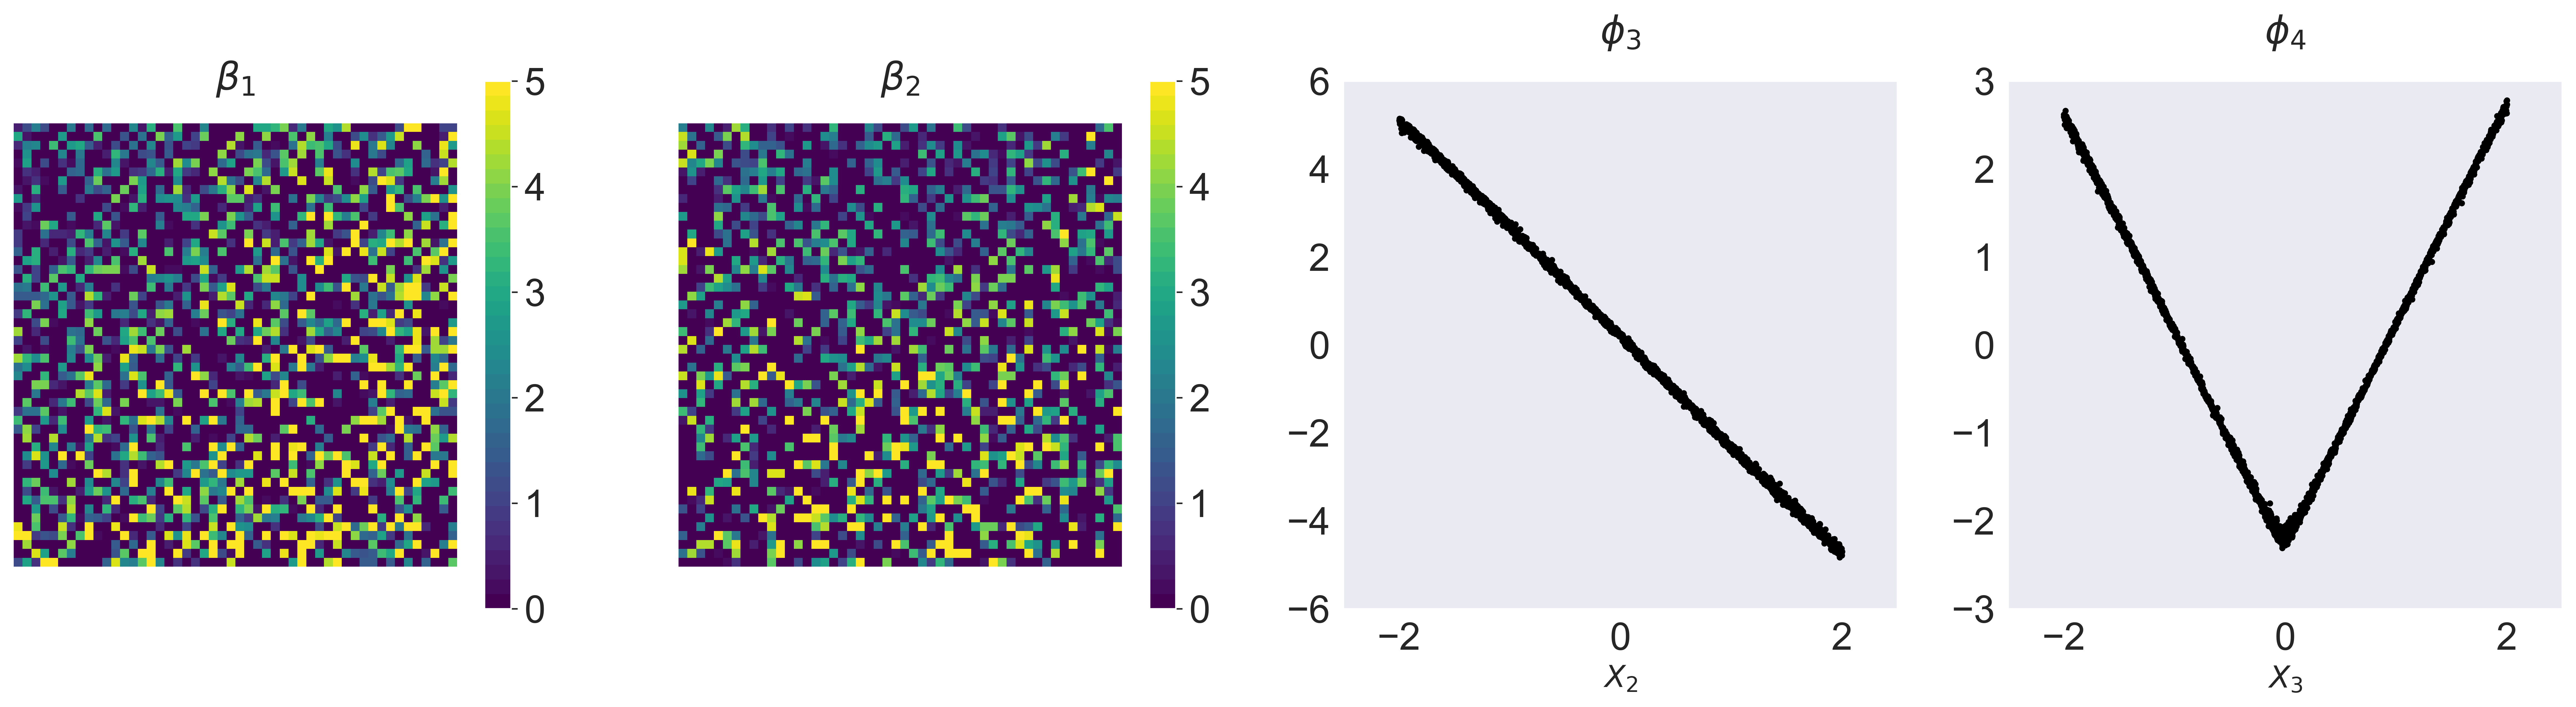

In [79]:
plot_s(pred_b, k=4, sub_titles=sub_titles, vmin=0, vmax=5, title='Synthetic data validation - ConformalSHAP + Noise',
       non_spatial=[2, 3], size=size)

In [81]:
pred_b_shap = [pred_results['X1_shap'].values,
               pred_results['X2_shap'].values,
               [X_coords.values[:, 2], pred_results['X3_shap'].values, -3, 3],
               [X_coords.values[:, 3], pred_results['X4_shap'].values, -3, 3]]

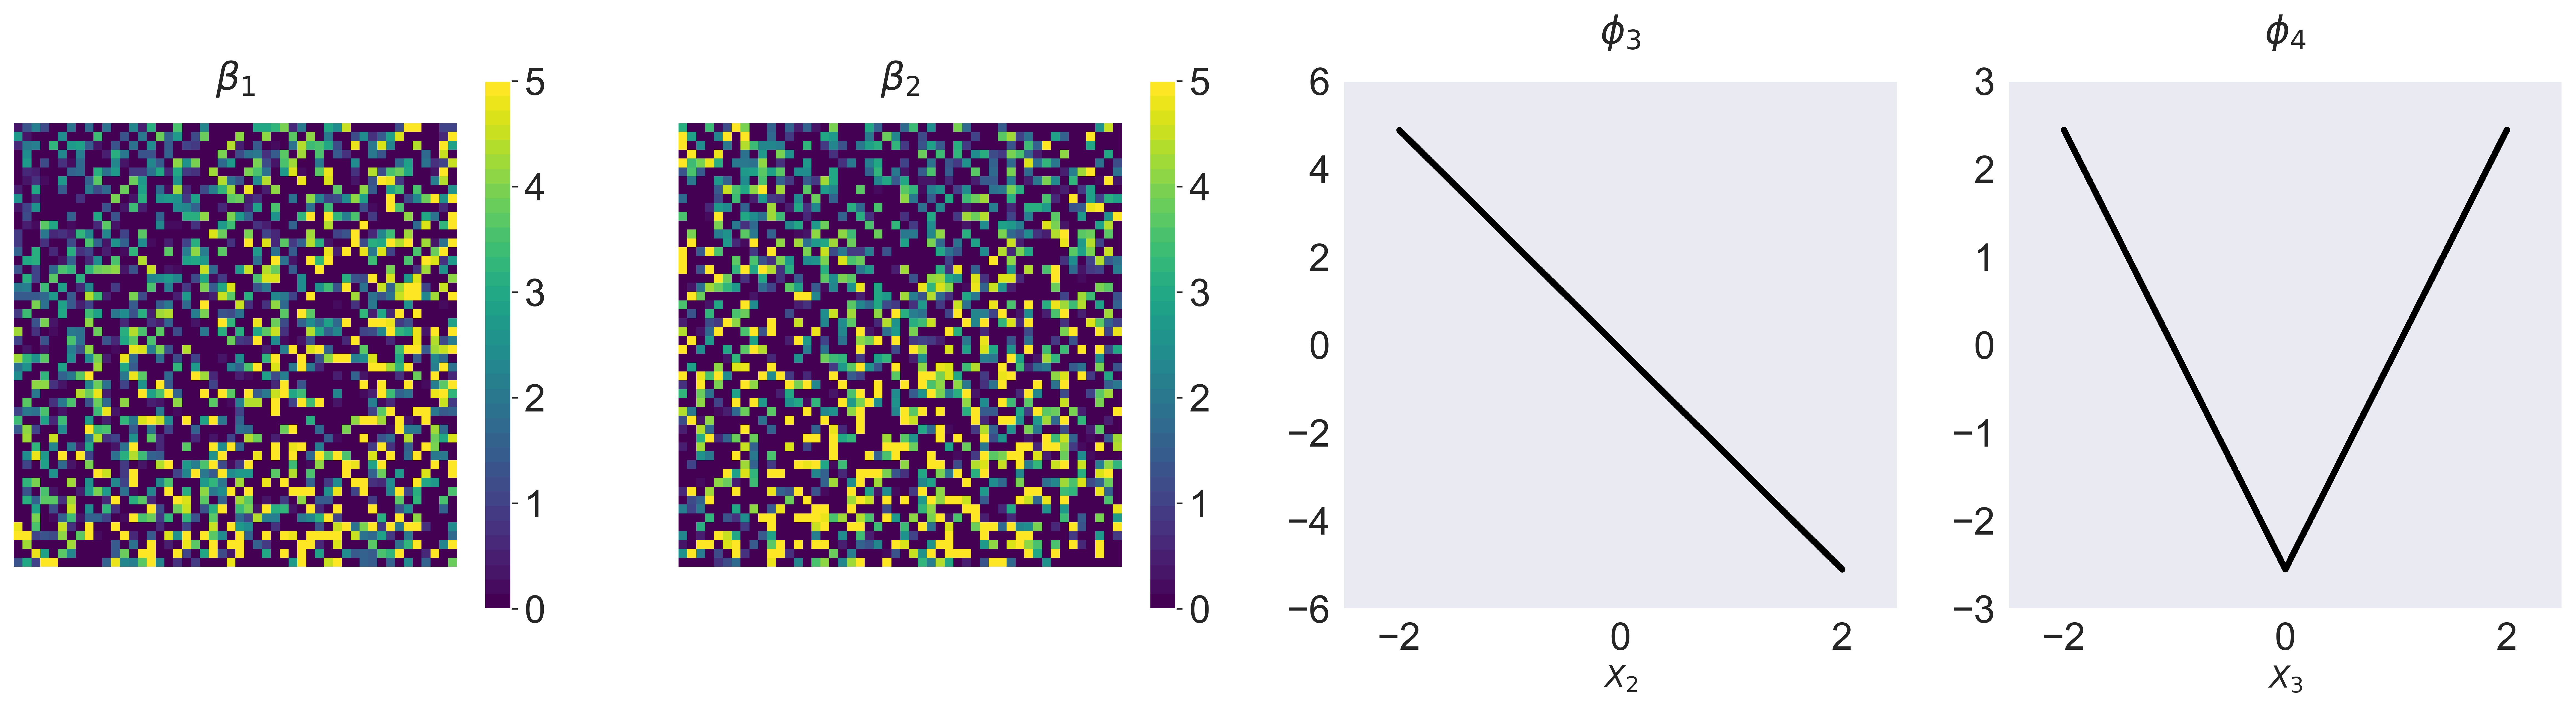

In [82]:
plot_s(pred_b_shap, k=4, sub_titles=sub_titles, vmin=0, vmax=5, title='Synthetic data validation + Noise',
       non_spatial=[2, 3], size=size)

In [51]:
shap_pred_gwr = results.get_svc(cols=[0, 1], coef_type='gwr', bw_max=10)

In [54]:
pred_b_ = [shap_pred_gwr[:, 0],
           shap_pred_gwr[:, 1],
           [X_coords.values[:, 2], pred_results['X3_pred'].values, -1, 5],
           [X_coords.values[:, 3], pred_results['X4_pred'].values, -1, 5]]

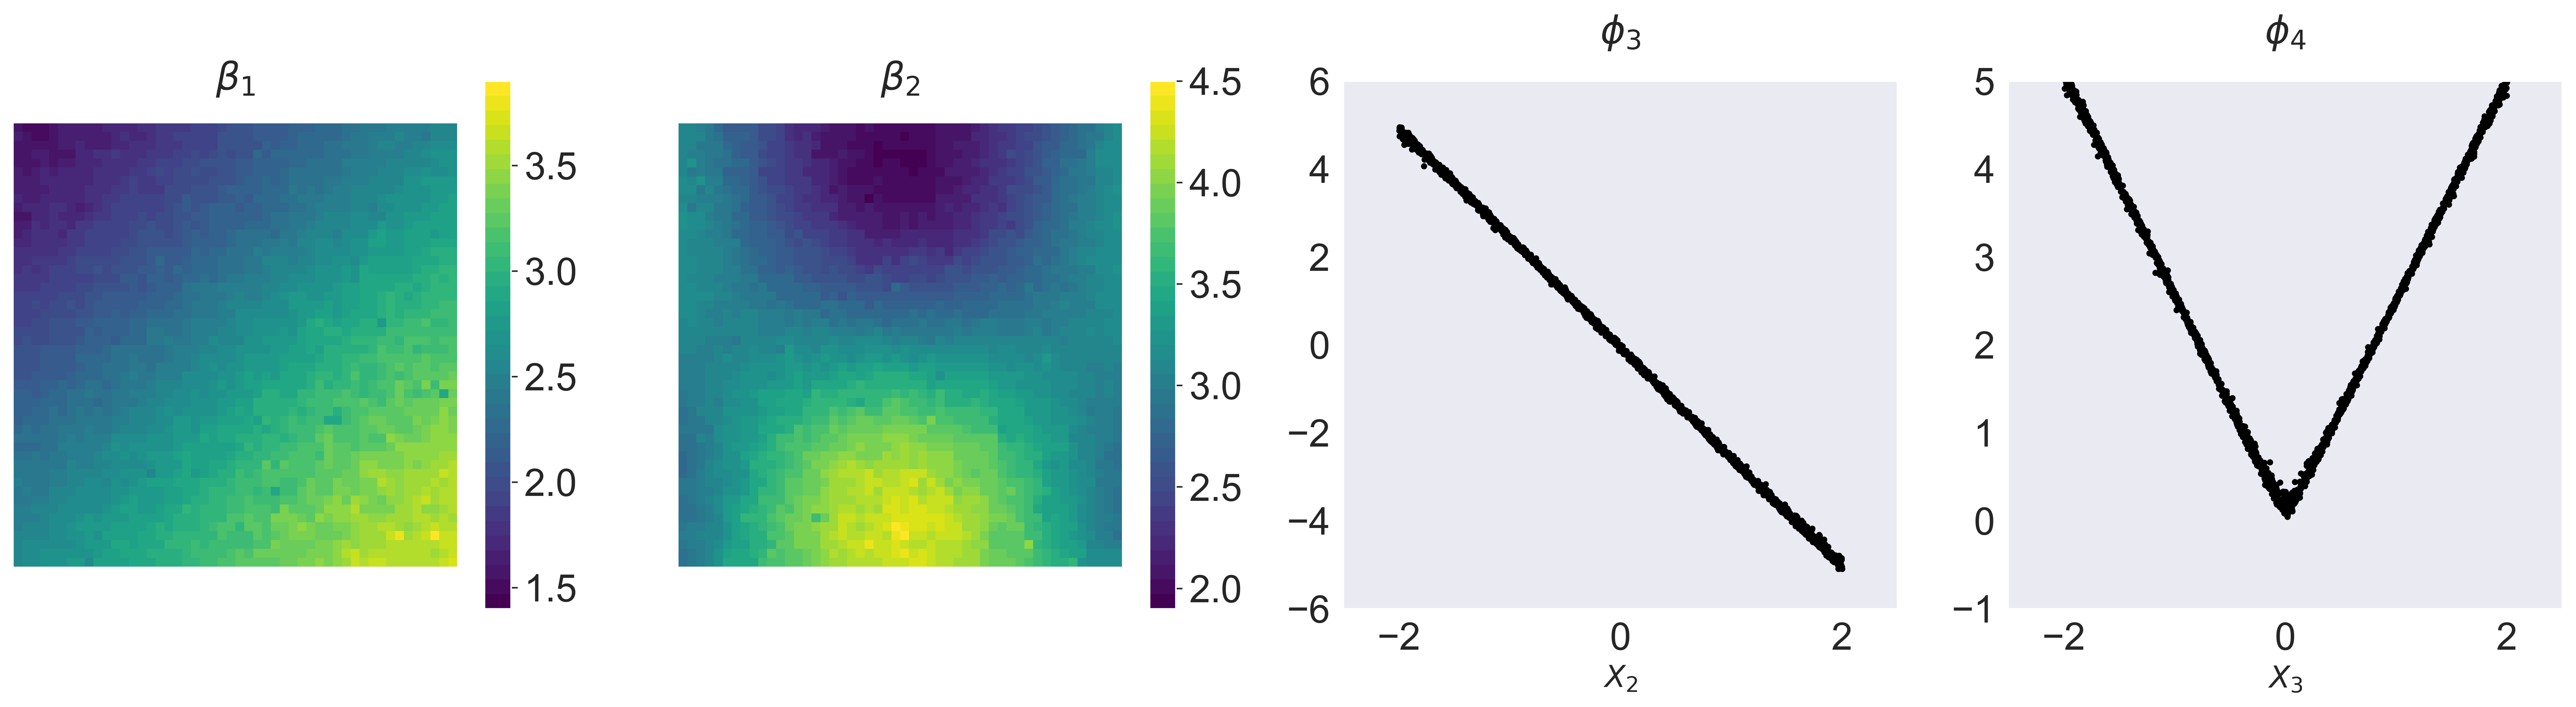

In [55]:
plot_s(pred_b_, k=4, sub_titles=sub_titles, title='Synthetic data validation - ConformalSHAPSmoothed + Noise',
       non_spatial=[2, 3], size=size)

In [47]:
X1_cover = (pred_results['X1_shap'] <= pred_results['X1_upper_bound']) & (
        pred_results['X1_shap'] >= pred_results['X1_lower_bound'])

In [48]:
X2_cover = (pred_results['X2_shap'] <= pred_results['X2_upper_bound']) & (
        pred_results['X2_shap'] >= pred_results['X2_lower_bound'])

In [49]:
b_cover = [X1_cover.values, X2_cover.values]

In [50]:
sub_titles = [r'$Cover_1$', r'$Cover_2$']

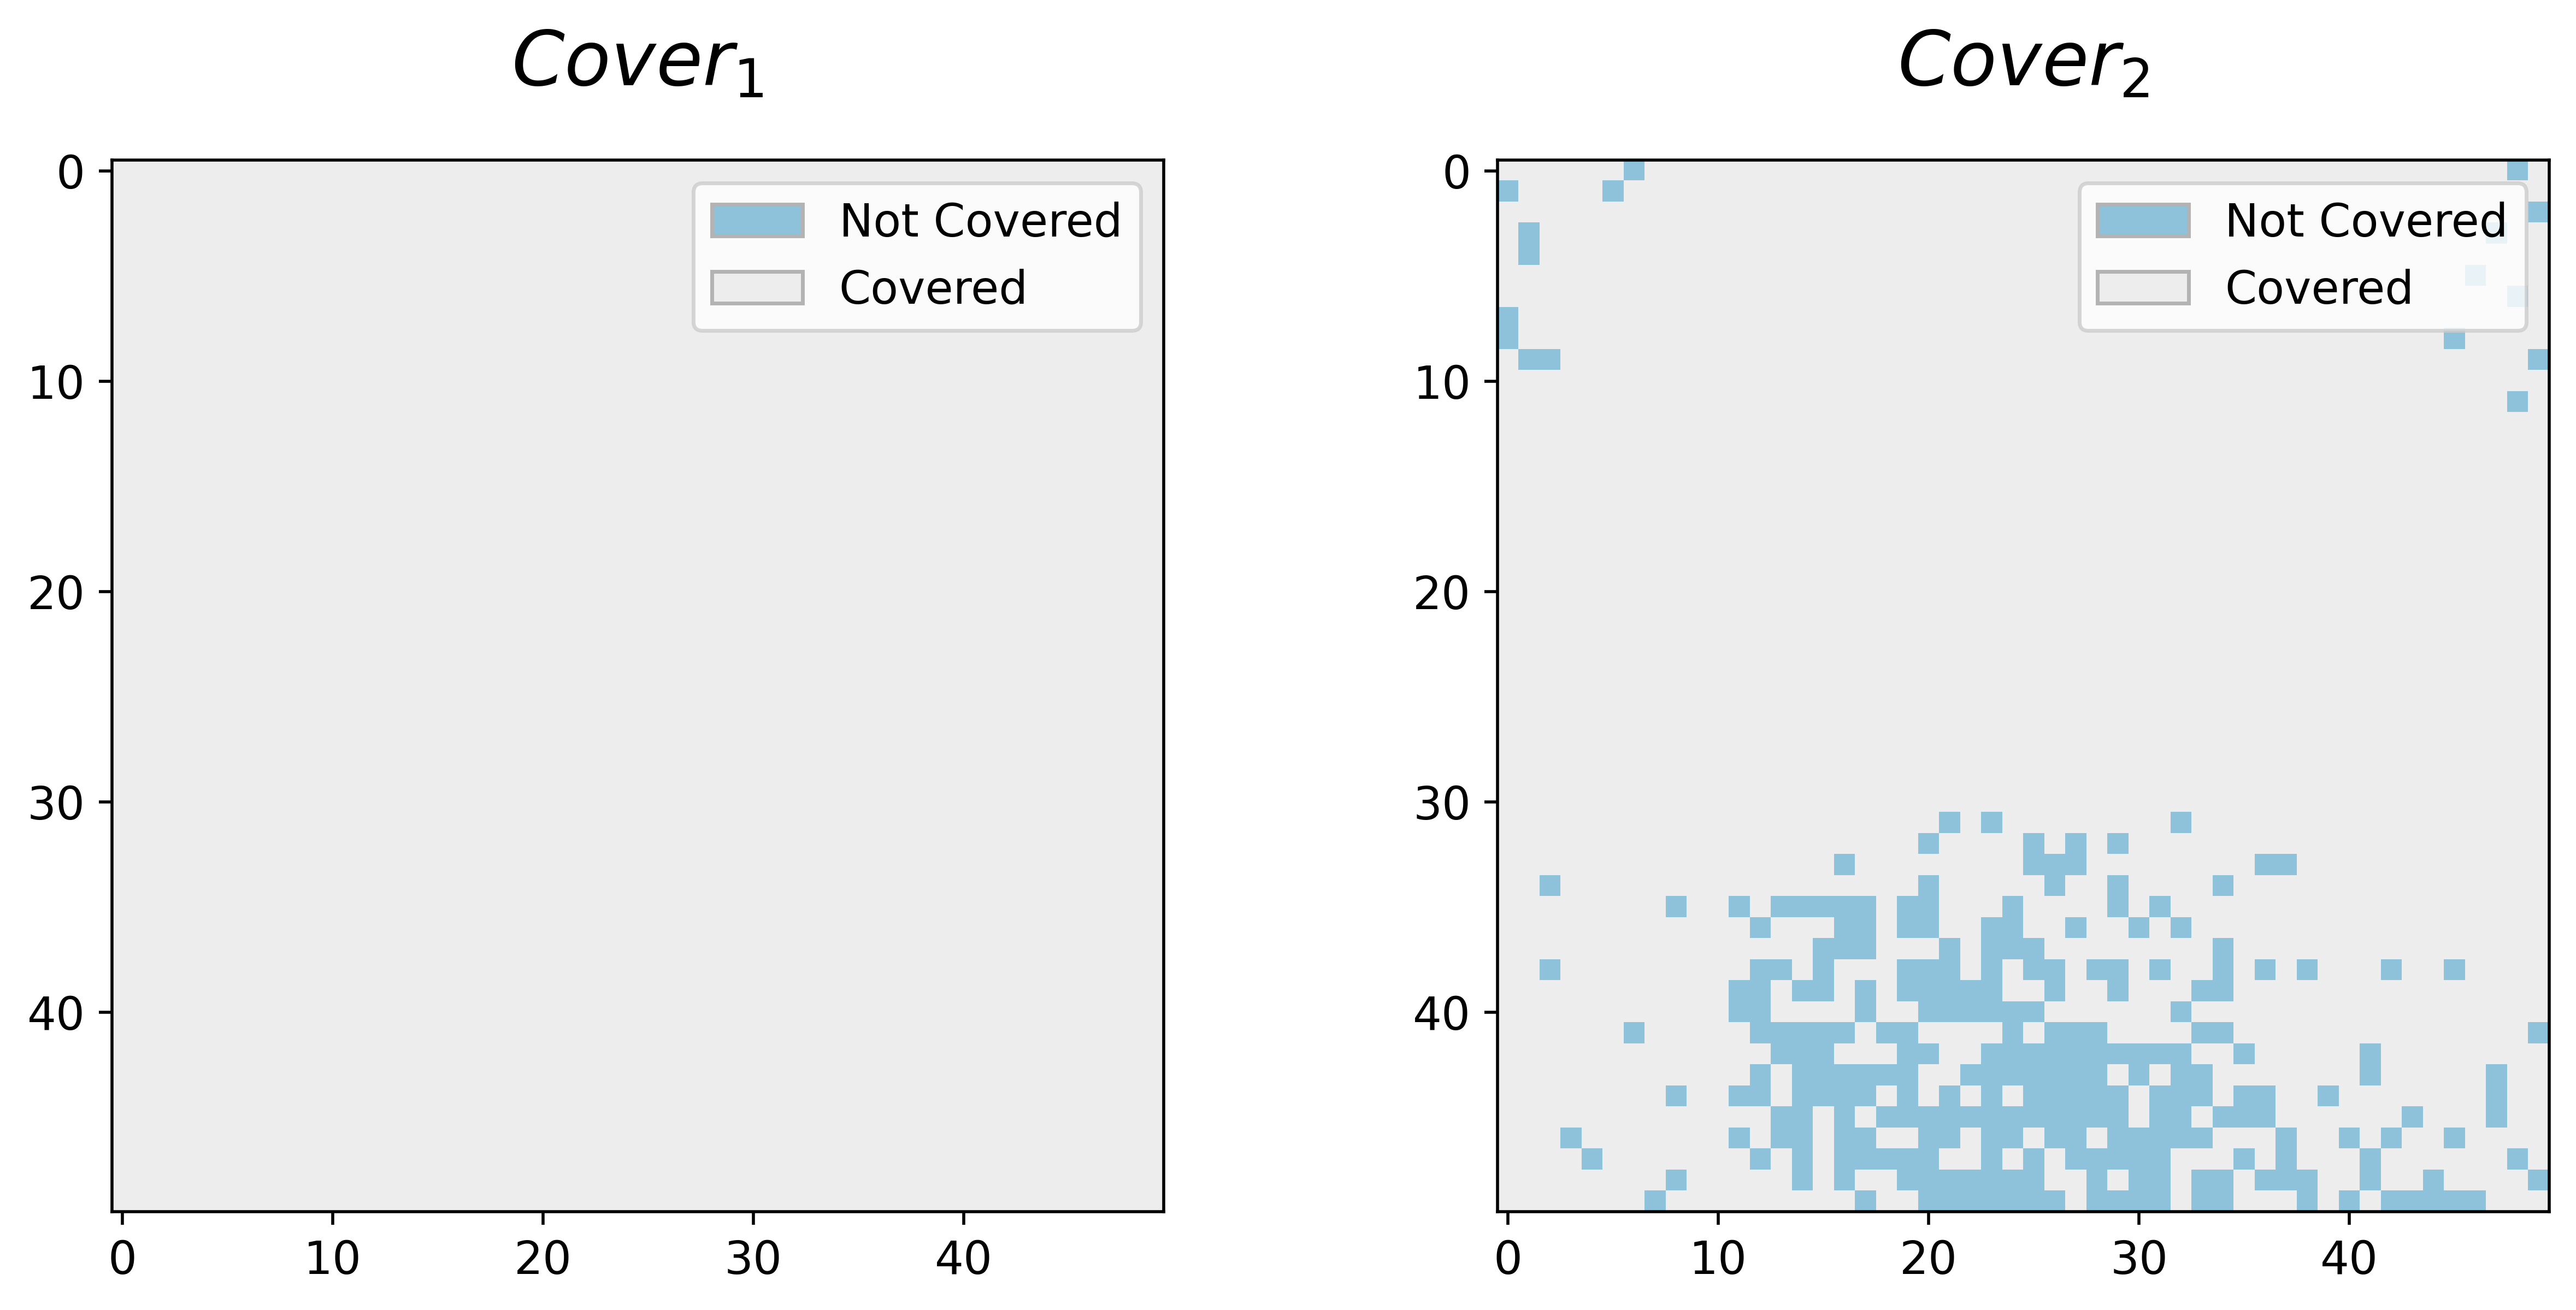

In [51]:
binary_cmap = ListedColormap(['#8ec1da', '#ededed'])
plot_coverage(b_cover, k=2, sub_titles=[r'$Cover_1$', r'$Cover_2$'], colors=['#8ec1da', '#ededed'],
              cmap=binary_cmap, title='Coverage - ConformalSHAP + Noise')

In [102]:
X1_geo_uncertainty = pred_results['X1_geo_uncertainty'].values.reshape(-1)
X2_geo_uncertainty = pred_results['X2_geo_uncertainty'].values.reshape(-1)

geo_uncertainty_list = [X1_geo_uncertainty, X2_geo_uncertainty]
sub_titles_uncertainty = [r'$Uncertainty_{X_1}(u,v)$', r'$Uncertainty_{X_2}(u,v)$']

In [85]:
from matplotlib.colors import LinearSegmentedColormap

In [86]:
colors = ['#326b77', '#efebd9', '#a74d30']
unc_cmap = LinearSegmentedColormap.from_list('uncertainty', colors, N=256)

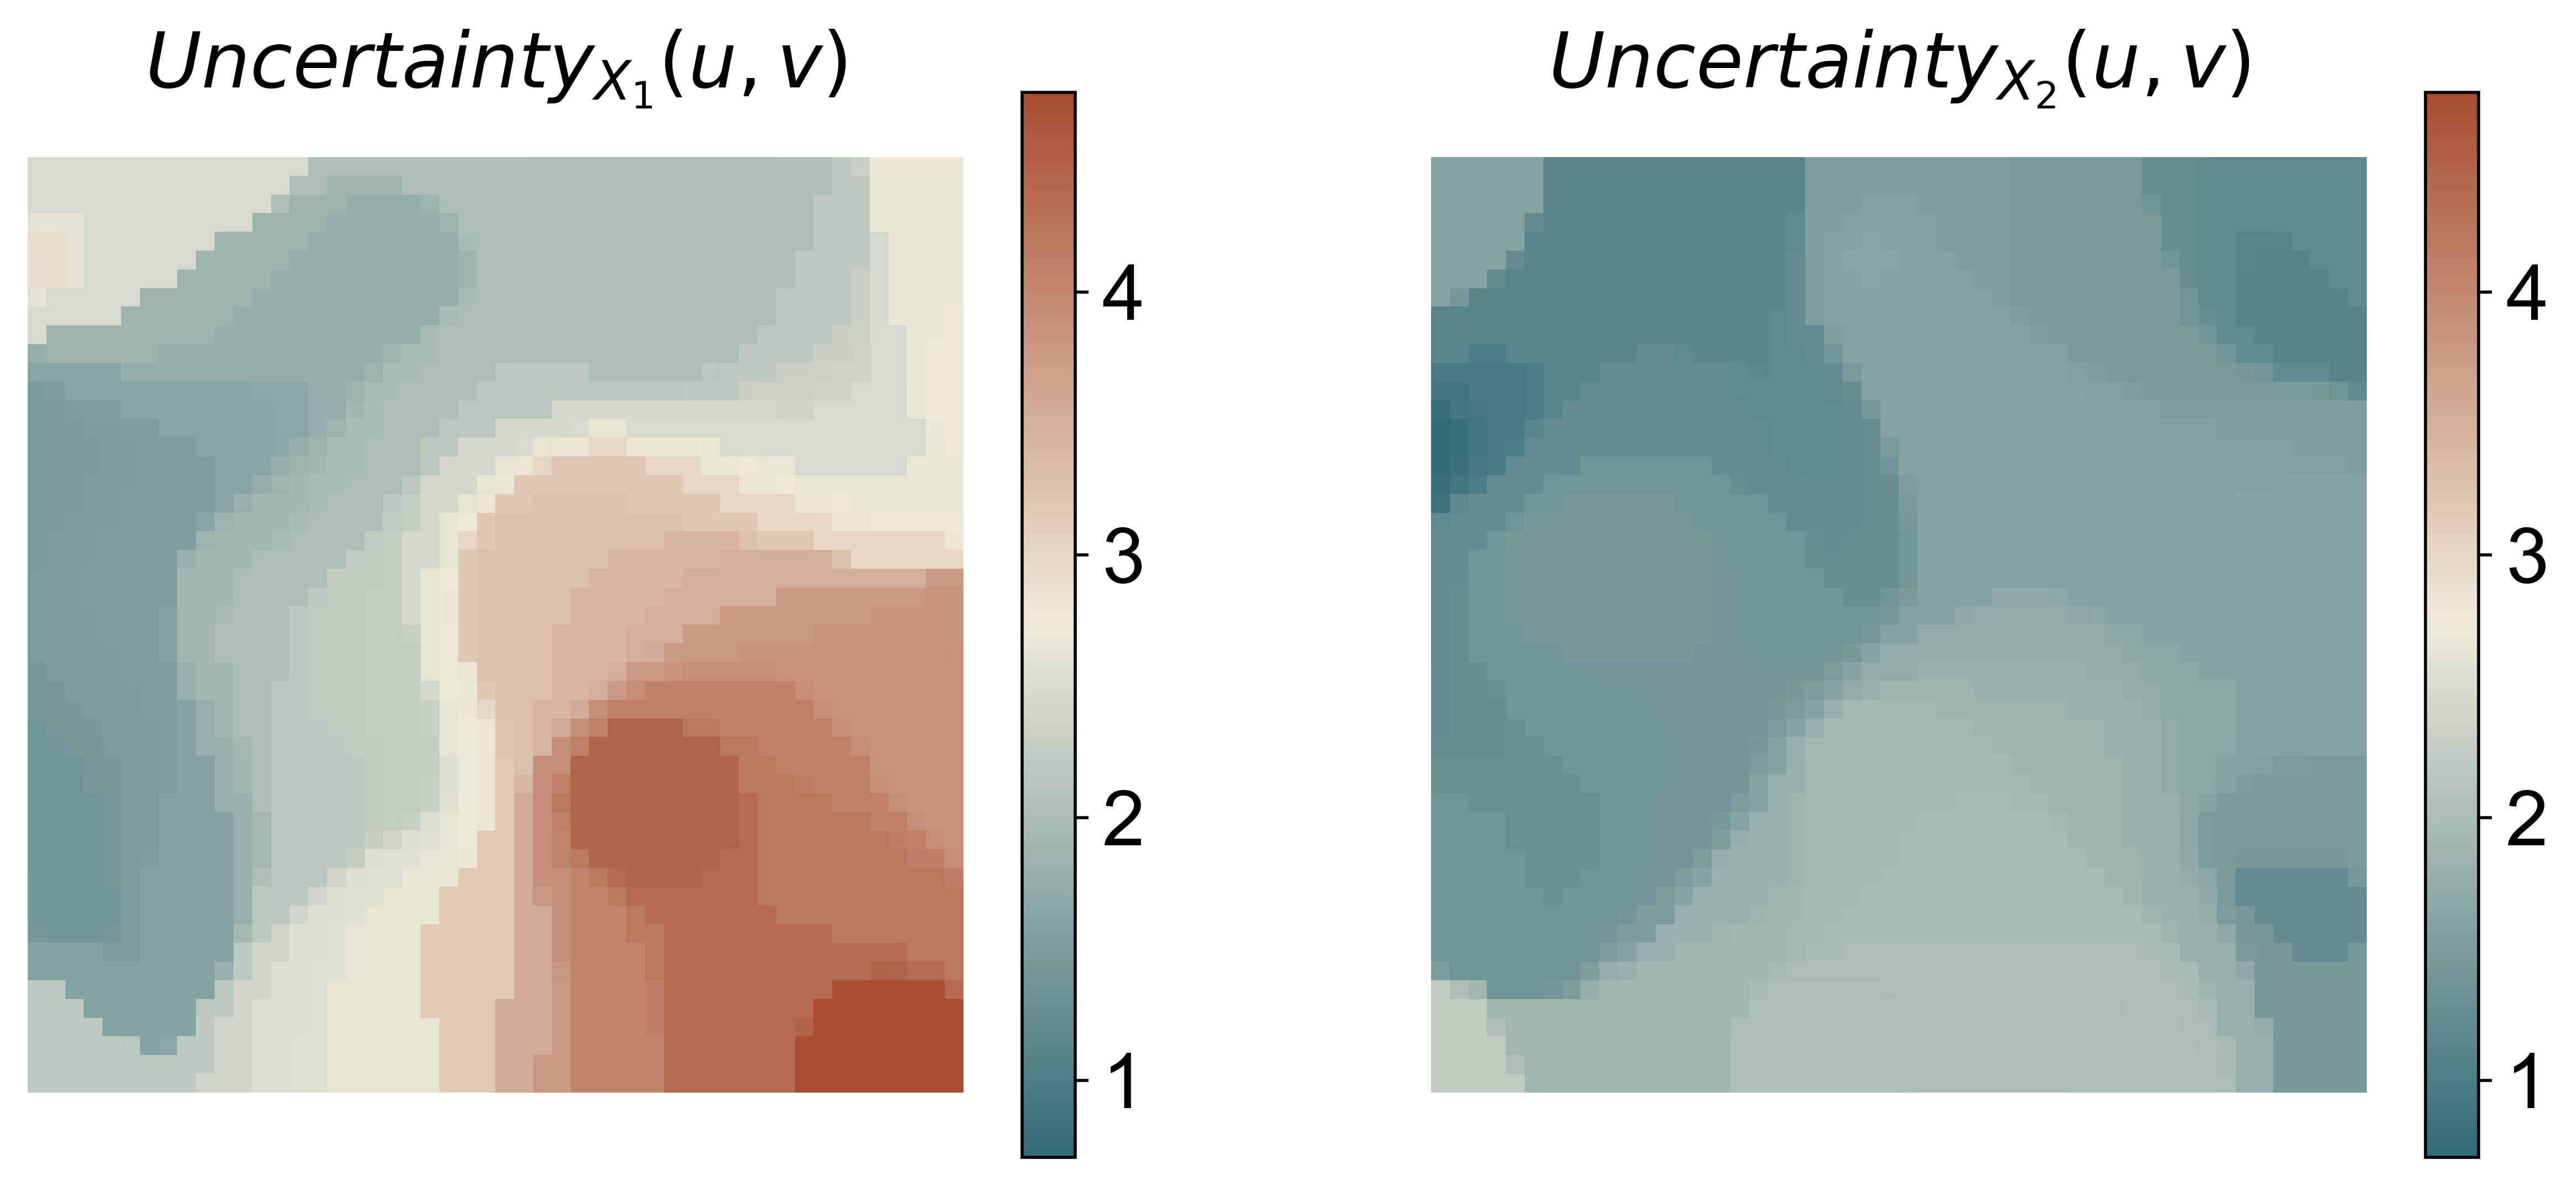

In [106]:
plot_s(geo_uncertainty_list, k=2, sub_titles=sub_titles_uncertainty,
       filename='./results_true_and_noise/noise200_model_uncertainty.pdf',
       non_spatial=[], size=size, cmap=unc_cmap, vmin=np.min(geo_uncertainty_list), vmax=np.max(geo_uncertainty_list))

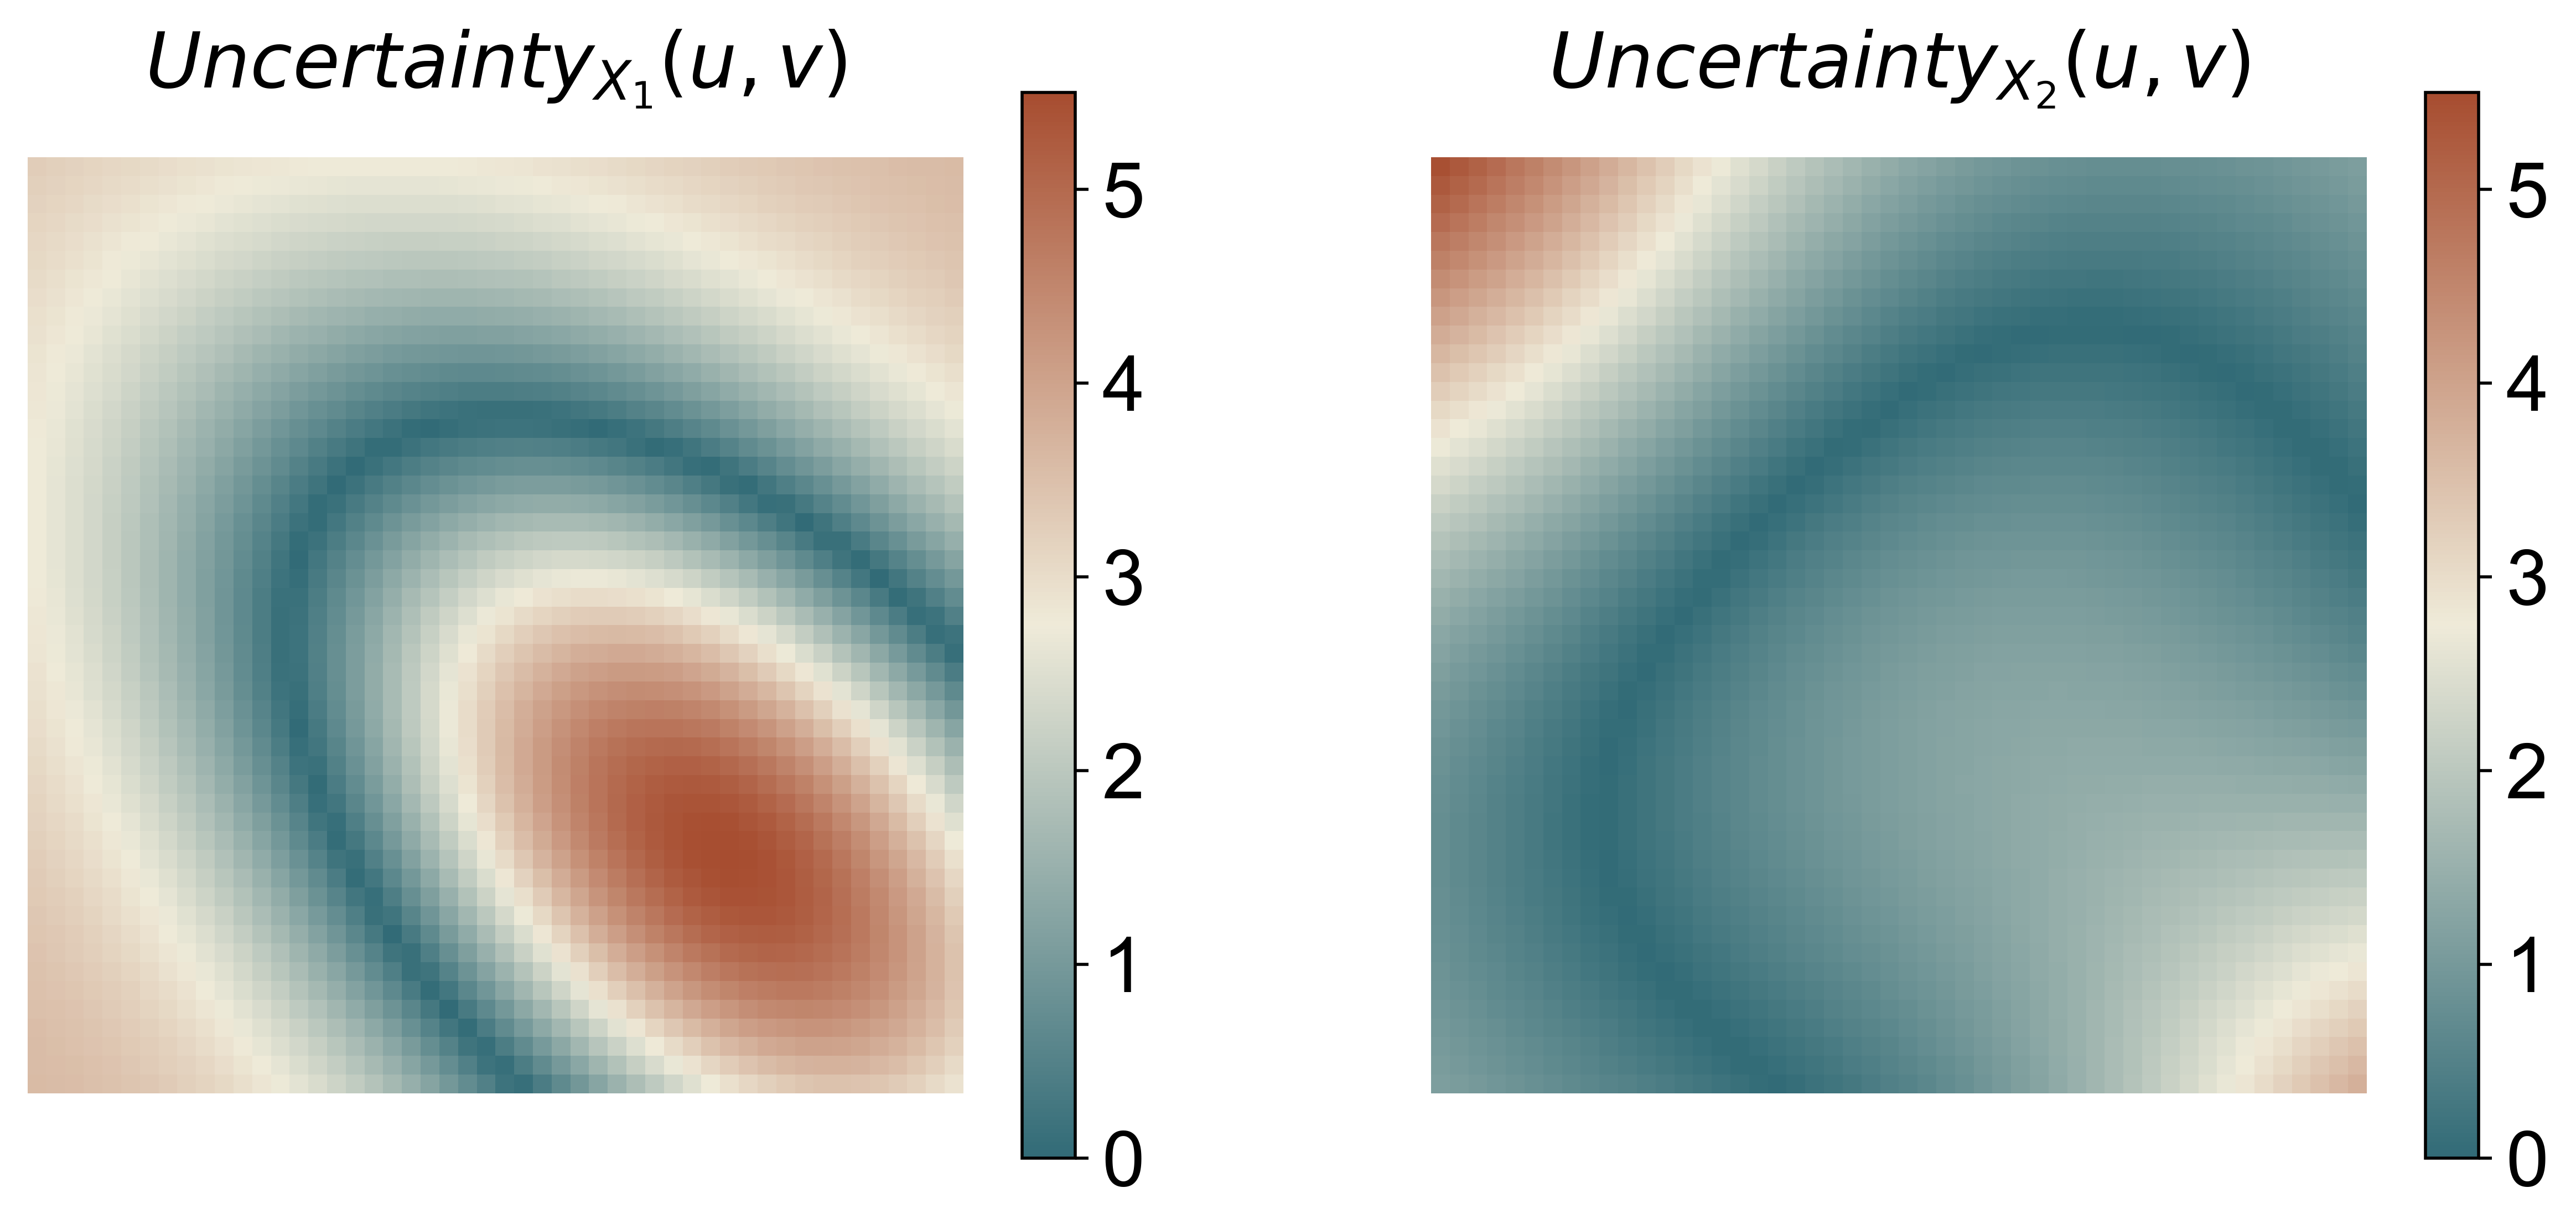

In [153]:
plot_s([np.abs(n1_ * 100), np.abs(n3_ * 100)], k=2, sub_titles=sub_titles_uncertainty, non_spatial=[], size=size, cmap=unc_cmap, filename='./true_uncertainty.png')

In [54]:
X1_uncertainty_shap = pred_results[['X1_geo_uncertainty', 'X1_shap_abs', 'x', 'y']]
X1_uncertainty_shap.columns = ['geo_uncertainty', 'shap_abs', 'x', 'y']

In [55]:
X2_uncertainty_shap = pred_results[['X2_geo_uncertainty', 'X2_shap_abs', 'x', 'y']]
X2_uncertainty_shap.columns = ['geo_uncertainty', 'shap_abs', 'x', 'y']

In [56]:
uncertainty_list = [X1_uncertainty_shap, X2_uncertainty_shap]

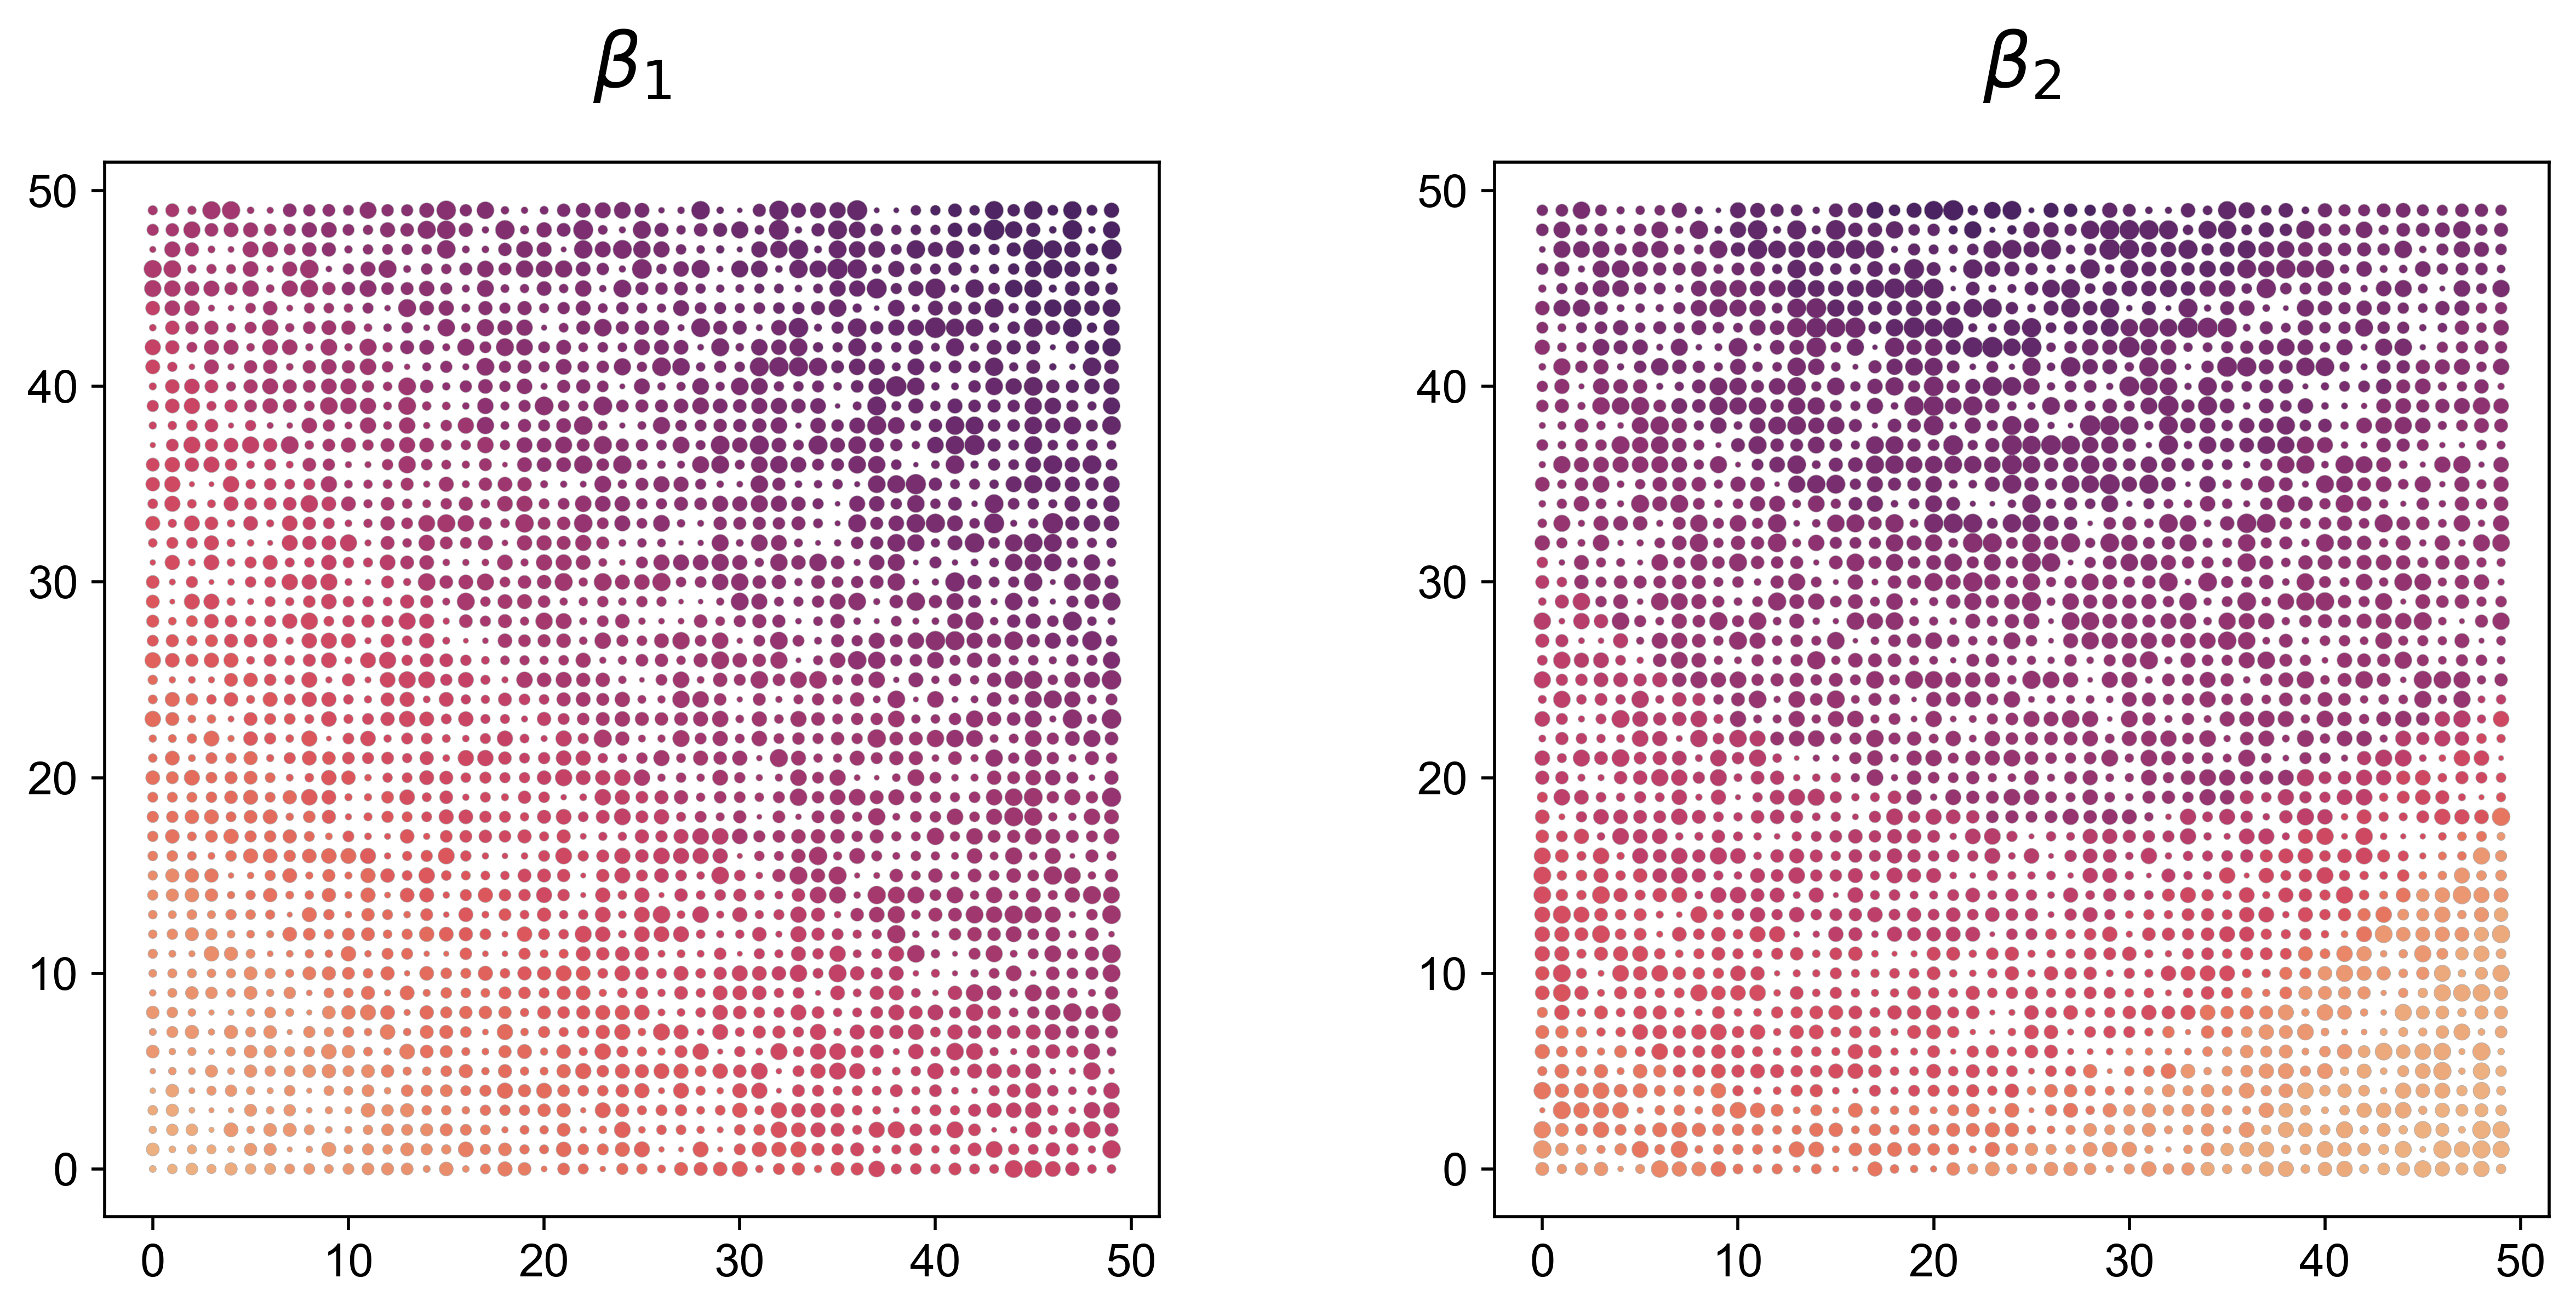

In [57]:
plot_uncertainty(uncertainty_list, k=2, sub_titles=[r'$\beta_1$', r'$\beta_2$'], s_limits=(2, 30),
                 title='Synthetic Data -Uncertainty - ExactSHAP + Noise')

In [127]:
result_X1_20 = pd.read_csv('./results_uniform_noise/results_20_noise-uniform_X1_and_X2.csv')

In [42]:
X1_geo_uncertainty = result_X1_20['X1_geo_uncertainty'].values.reshape(-1)
X2_geo_uncertainty = result_X1_20['X2_geo_uncertainty'].values.reshape(-1)

geo_uncertainty_list = [X1_geo_uncertainty, X2_geo_uncertainty]
sub_titles_uncertainty = [r'$U_1(u,v)$', r'$U_2(u,v)$']

NameError: name 'result_X1_20' is not defined

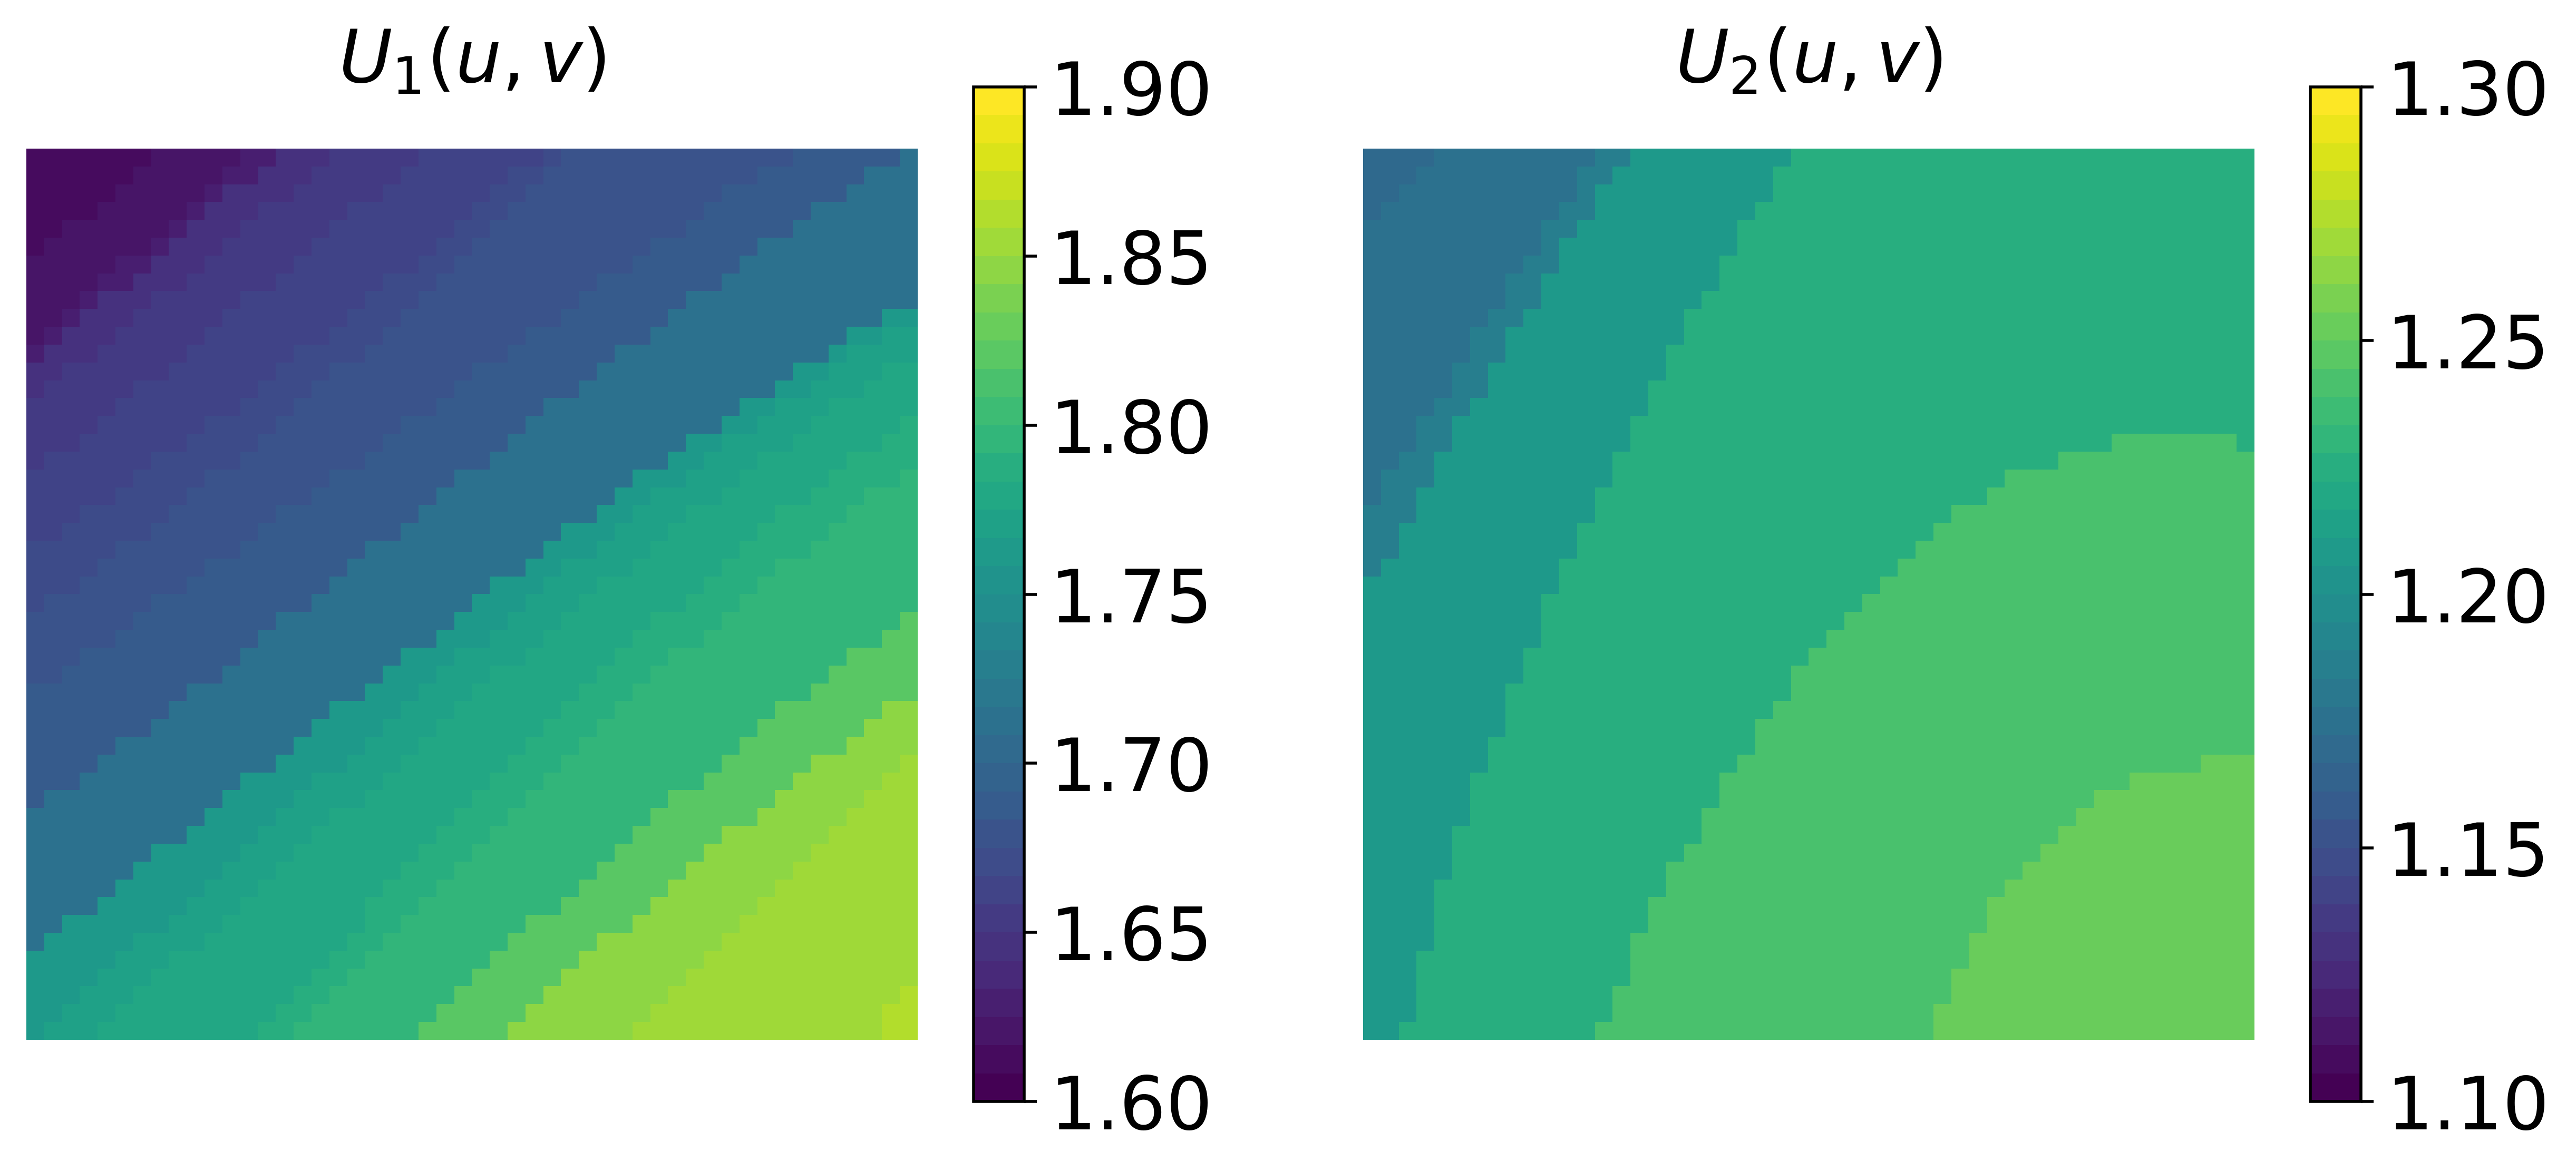

In [129]:
plot_s(geo_uncertainty_list, k=2, sub_titles=sub_titles_uncertainty,
       title='UncertaintyOfCoef - ConformalSHAPSmoothed + Noise',
       non_spatial=[], size=size)

In [130]:
result_X1_100 = pd.read_csv('./results_uniform_noise/results_100_noise-uniform_X1_and_X2.csv')

In [131]:
X1_geo_uncertainty = result_X1_100['X1_geo_uncertainty'].values.reshape(-1)
X2_geo_uncertainty = result_X1_100['X2_geo_uncertainty'].values.reshape(-1)

geo_uncertainty_list = [X1_geo_uncertainty, X2_geo_uncertainty]
sub_titles_uncertainty = [r'$U_1(u,v)$', r'$U_2(u,v)$']

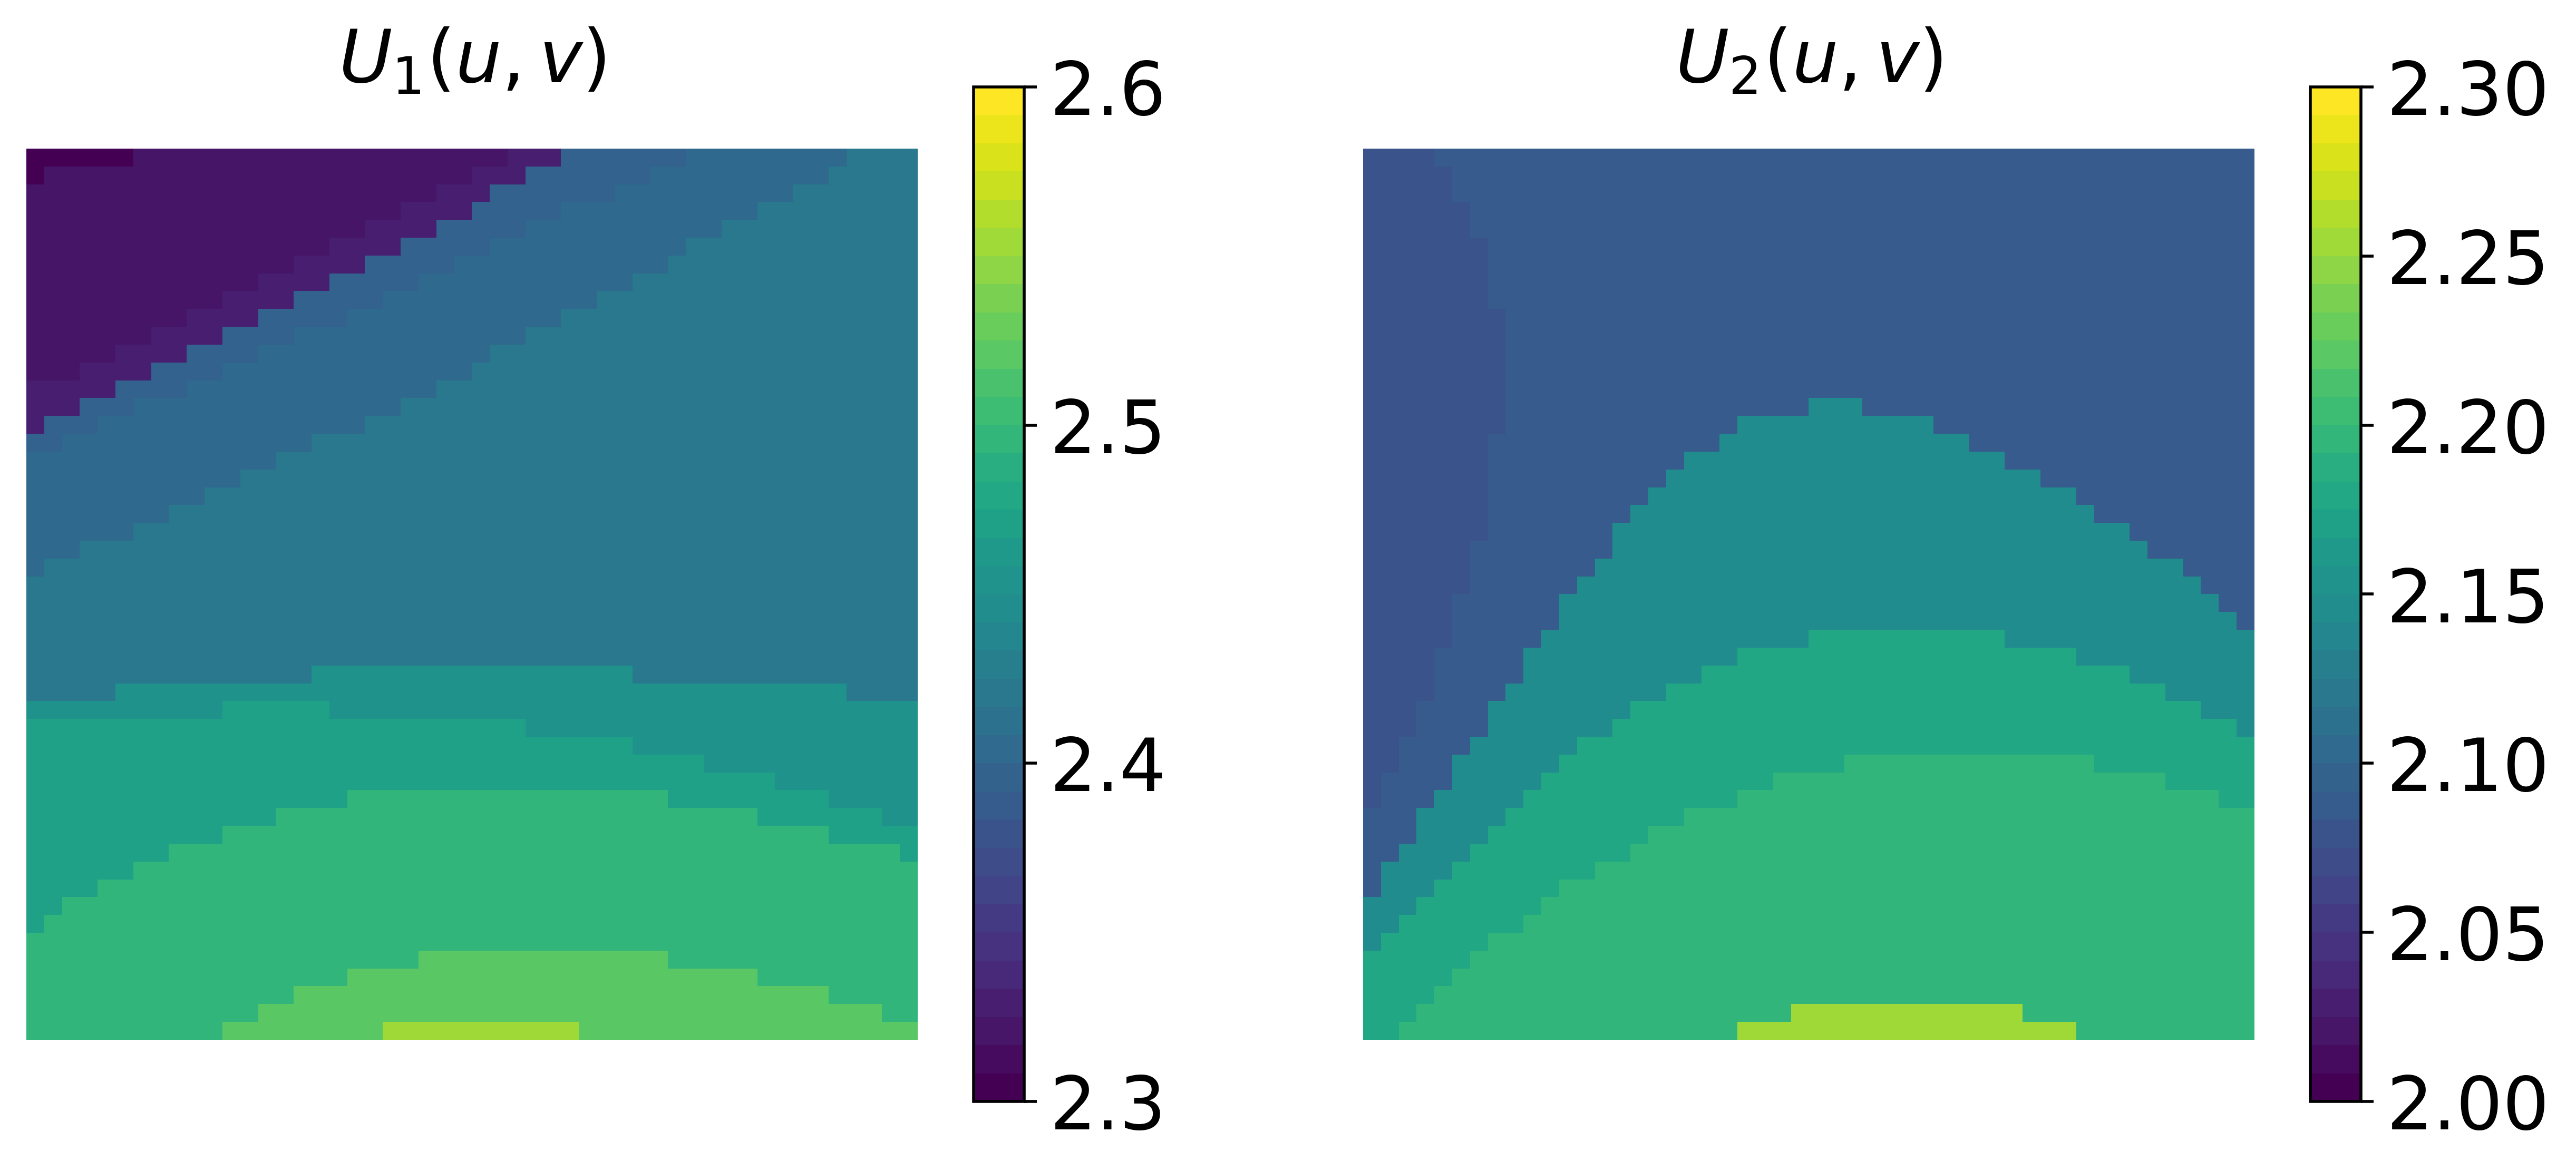

In [132]:
plot_s(geo_uncertainty_list, k=2, sub_titles=sub_titles_uncertainty,
       title='UncertaintyOfCoef - ConformalSHAPSmoothed + Noise',
       non_spatial=[], size=size)

In [72]:
results = {}
groups = ['true', 'noise50', 'noise100', 'noise200']

for group in groups:
    if group == 'true':
        prediction_function = true_model_predict
    elif group == 'noise50':
        prediction_function = noise_50_model_predict
    elif group == 'noise100':
        prediction_function = noise_100_model_predict
    elif group == 'noise200':
        prediction_function = noise_200_model_predict
    explainer = GeoConformalizedExplainer(prediction_f=prediction_function,
                                          x_train=X_train,
                                          x_calib=X_calib,
                                          coord_calib=loc_calib.values,
                                          miscoverage_level=0.1,
                                          band_width=15,
                                          shap_value_f=lambda x_: shap_value_f(x_, prediction_function),
                                          feature_names=X_calib.columns)
    result = explainer.uncertainty_aware_explain(x_test=X_coords, coord_test=loc.values)
    gdf = result.result_geo
    X1_geo_uncertainty = gdf['X1_geo_uncertainty'].values.reshape(-1)
    X2_geo_uncertainty = gdf['X2_geo_uncertainty'].values.reshape(-1)
    results[f'{group}_X1'] = X1_geo_uncertainty
    results[f'{group}_X2'] = X2_geo_uncertainty
    vmin_X1 = np.min(X1_geo_uncertainty)
    vmax_X1 = np.max(X1_geo_uncertainty)
    vmin_X2 = np.min(X2_geo_uncertainty)
    vmax_X2 = np.max(X2_geo_uncertainty)
    results[f'{group}_X1_vmax'] = vmax_X1
    results[f'{group}_X2_vmax'] = vmax_X2
    results[f'{group}_X1_vmin'] = vmin_X1
    results[f'{group}_X2_vmin'] = vmin_X2


Explaining Variables
Explaining Variables
Explaining Variables
Explaining Variables


In [42]:
from matplotlib.colors import LinearSegmentedColormap

colors = ['#326b77', '#efebd9', '#a74d30']
unc_cmap = LinearSegmentedColormap.from_list('uncertainty', colors, N=256)

In [54]:
true_uncertainty = n1 * 50 * X_coords.iloc[:, 0].values.reshape(50, 50)

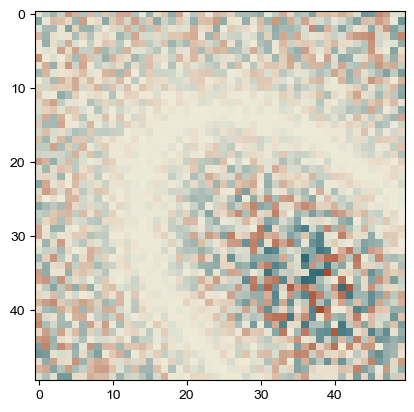

In [55]:
plt.imshow(true_uncertainty, cmap=unc_cmap)

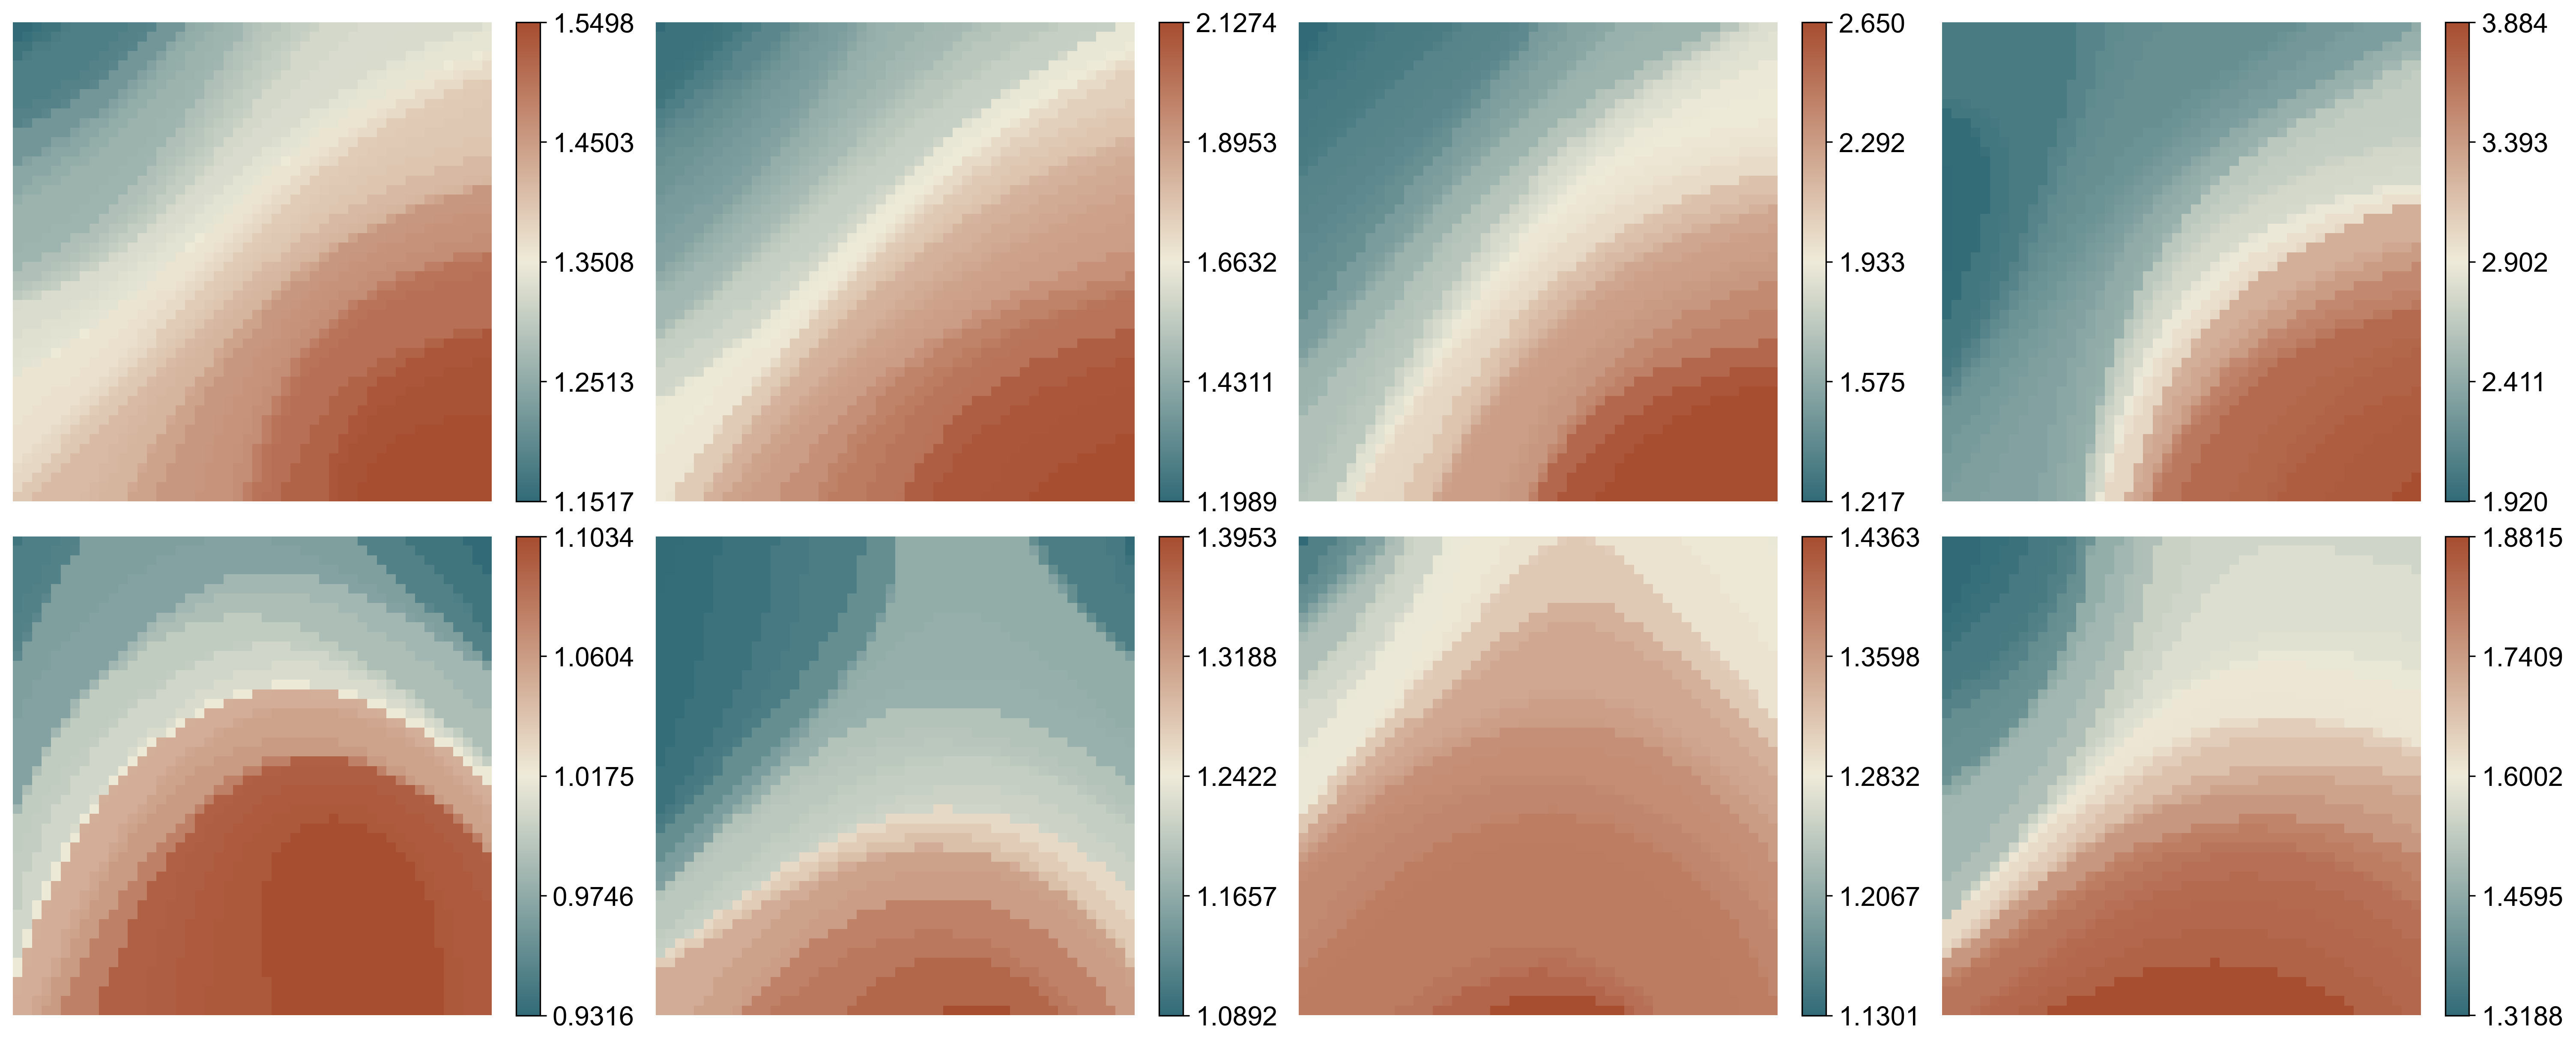

In [73]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8), dpi=300, constrained_layout=True)

X1_geo_uncertainty_base = results['true_X1'].reshape(size, size)
X2_geo_uncertainty_base = results['true_X2'].reshape(size, size)

for i, group in enumerate(groups):
    X1_geo_uncertainty = results[f'{group}_X1'].reshape(size, size)
    X2_geo_uncertainty = results[f'{group}_X2'].reshape(size, size)
    geo_uncertainty_list = [X1_geo_uncertainty, X2_geo_uncertainty]
    vmax_X1 = results[f'{group}_X1_vmax']
    vmax_X2 = results[f'{group}_X2_vmax']
    vmin_X1 = results[f'{group}_X1_vmin']
    vmin_X2 = results[f'{group}_X2_vmin']
    # vmax_X1 = np.max(X1_geo_uncertainty)
    # vmax_X2 = np.max(X2_geo_uncertainty)
    # vmin_X1 = np.min(X1_geo_uncertainty)
    # vmin_X2 = np.min(X2_geo_uncertainty)

    for j in range(2):
        if j == 0:
            v_min = vmin_X1
            v_max = vmax_X1
        elif j == 1:
            v_min = vmin_X2
            v_max = vmax_X2
        ax = axes[j][i]
        # c = ax.imshow(geo_uncertainty_list[j].reshape(size, size), cmap=unc_cmap)
        c = ax.imshow(geo_uncertainty_list[j].reshape(size, size), cmap=unc_cmap, vmin=v_min, vmax=v_max)
        cb = fig.colorbar(c, ax=ax, shrink=1)
        cb.ax.tick_params(labelsize=15)
        ticks = np.linspace(v_min, v_max, num=5)
        cb.set_ticks(ticks)
        ax.set_xticks(np.arange(-0.5, size, 5))
        ax.set_yticks(np.arange(-0.5, size, 5))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_axis_off()
        ax.tick_params(axis='x', colors=(0, 0, 0, 0))
        ax.tick_params(axis='y', colors=(0, 0, 0, 0))

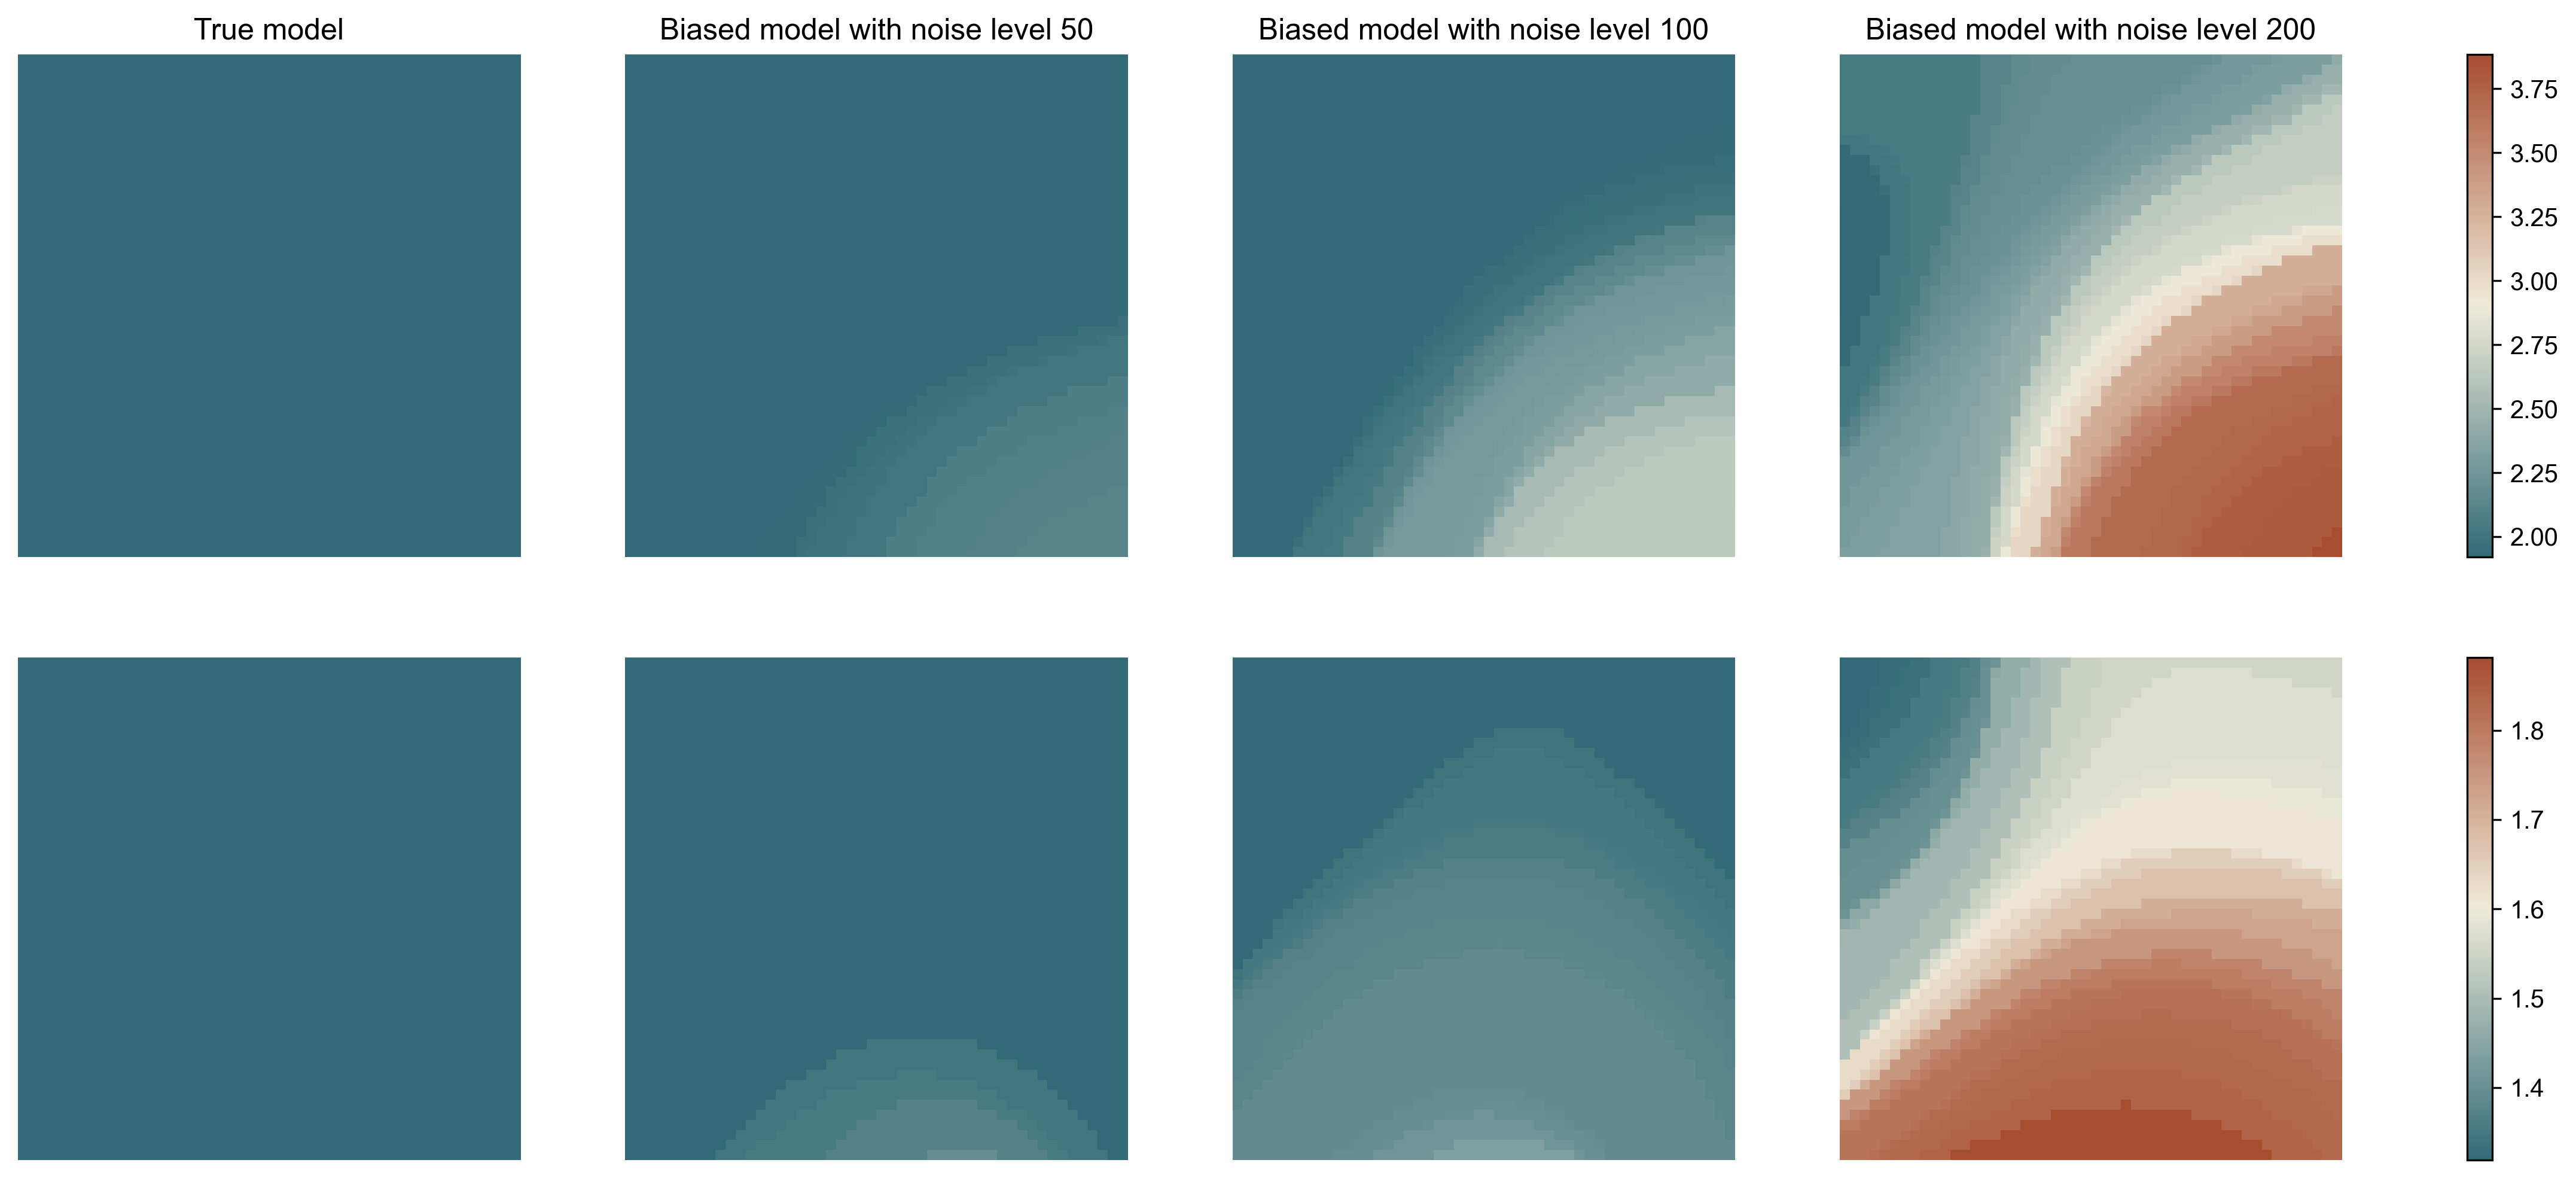

In [74]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8), dpi=300)

vmax_X1 = results[f'{groups[3]}_X1_vmax']
vmin_X1 = results[f'{groups[3]}_X1_vmin']
vmax_X2 = results[f'{groups[3]}_X2_vmax']
vmin_X2 = results[f'{groups[3]}_X2_vmin']

sub_titles = ['True model', 'Biased model with noise level 50', 'Biased model with noise level 100', 'Biased model with noise level 200']

for i, group in enumerate(groups):
    X1_geo_uncertainty = results[f'{group}_X1'].reshape(size, size)
    im1 = axes[0, i].imshow(X1_geo_uncertainty, vmin=vmin_X1, vmax=vmax_X1, cmap=unc_cmap)
    axes[0, i].set_xticks(np.arange(-0.5, size, 5))
    axes[0, i].set_yticks(np.arange(-0.5, size, 5))
    axes[0, i].set_xticklabels([])
    axes[0, i].set_yticklabels([])
    axes[0, i].set_axis_off()
    axes[0, i].tick_params(axis='x', colors=(0, 0, 0, 0))
    axes[0, i].tick_params(axis='y', colors=(0, 0, 0, 0))
    axes[0, i].set_title(f'{sub_titles[i]}')

# Plot second row
for i, group in enumerate(groups):
    X2_geo_uncertainty = results[f'{group}_X2'].reshape(size, size)
    im2 = axes[1, i].imshow(X2_geo_uncertainty, vmin=vmin_X2, vmax=vmax_X2, cmap=unc_cmap)
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])
    axes[1, i].set_xticks(np.arange(-0.5, size, 5))
    axes[1, i].set_yticks(np.arange(-0.5, size, 5))
    axes[1, i].set_xticklabels([])
    axes[1, i].set_yticklabels([])
    axes[1, i].set_axis_off()
    axes[1, i].tick_params(axis='x', colors=(0, 0, 0, 0))
    axes[1, i].tick_params(axis='y', colors=(0, 0, 0, 0))

fig.colorbar(im1, ax=axes[0, :], orientation='vertical', fraction=0.02, pad=0.05)
fig.colorbar(im2, ax=axes[1, :], orientation='vertical', fraction=0.02, pad=0.05)

# plt.tight_layout()
# plt.savefig('./results_true_and_noise/true_and_biased_models.pdf', dpi=300, bbox_inches='tight')